In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import itertools
from collections import defaultdict
from collections import Counter
import io
import gurobipy as gp
from gurobipy import GRB
from itertools import combinations
from itertools import groupby
from random import sample
import math
import json
import random
import os
import csv

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ['Computer Modern Roman'],
})
%matplotlib ipympl

In [2]:
def n_sols(n,m,quer_dict,noise,n_sols,partial_dict = dict()):
    """ builds ILP to construct candidate database, based on answers to queries 
    Assumes bound on noise, n and m is known. """
    M = gp.Model()
    M.Params.OutputFlag = 0
    
    # Initialize the decision variables
    x = np.array([[M.addVar(vtype='B', name=f"x_{i}_{j}") 
                   for j in range(m)] for i in range(n)])
    # print(x)
    # partial_dict = dict()
    #adding the constraints...
    quer_cons(M,x,n,quer_dict,noise)
    partial_cons(M,x,n,partial_dict)
            
    # for i in range(n-1):
    #     M.addConstr(binatodeci(x[i]) <= binatodeci(x[i+1]))
    bin_cons(M,x,n)

    # Parameters
    M.Params.PoolSearchMode = 2
    M.Params.PoolSolutions = n_sols
    # m.Params.PoolSolutions = 2
    M.Params.PoolGap = 0.0

    # Optimize
    M.optimize()
    return M.SolCount

def gen_sols(n,m,quer_dict,partial_dict,noise,n_sols):
    """ builds ILP to construct candidate database, based on answers to queries 
    Assumes bound on noise, n and m is known. """
    M = gp.Model()
    M.Params.OutputFlag = 0
    
    # Initialize the decision variables
    x = np.array([[M.addVar(vtype='B', name=f"x_{i}_{j}") 
                   for j in range(m)] for i in range(n)])
    # print(x)
    
    #adding the constraints...
    quer_cons(M,x,n,quer_dict,noise)
    partial_cons(M,x,n,partial_dict)
            
    # for i in range(n-1):
    #     M.addConstr(binatodeci(x[i]) <= binatodeci(x[i+1]))
    bin_cons(M,x,n)

    # Parameters
    M.Params.PoolSearchMode = 2
    M.Params.PoolSolutions = n_sols
    # m.Params.PoolSolutions = 2
    M.Params.PoolGap = 0.0

    # Optimize
    M.optimize()
    
    # print(f"Took {M.Runtime:.2f} seconds to solve")
    
    if M.solCount == 0:
        print("infeasible")
        
    print(f'old_ILP: {M.SolCount} solutions')
    
    out_lst = []
    for k in range(M.SolCount):
        M.Params.SolutionNumber = k
        out_x = np.zeros_like(x)
        for i in range(len(x)):
            for j in range(len(x[0])):
                out_x[i][j] = x[i][j].Xn
        # print([var.Xn for var in m.getVars()])
        out_lst.append(out_x)
        
    return out_lst, M.Runtime

def quer_cons(M,x,n,quer_dict,noise):
    """ Adds the constraints based on the queries in quer_dict"""
    
    y_var_dict = defaultdict()
    y_p_var_dict = defaultdict()
    y_n_var_dict = defaultdict()
    
    for quer in quer_dict.keys():
        y_var_dict[quer] = []
        y_p_var_dict[quer] = []
        y_n_var_dict[quer] = []
        
        positions_0 = []
        positions_1 = []
        for i, j in zip(quer[0],quer[1]):
            if j == 0: 
                positions_0.append(i)
            elif j ==1:
                positions_1.append(i)
        for i in range(n):
            y_var_dict[quer].append(M.addVar(vtype='B', name=f"y_{quer}_{i}"))
            y_p_var_dict[quer].append(M.addVar(vtype='B', name=f"y_p_{quer}_{i}"))
            y_n_var_dict[quer].append(M.addVar(vtype='B', name=f"y_n_{quer}_{i}"))
            
            M.addConstr( len(quer[0])*y_var_dict[quer][i] + (len(quer[0])+0.5)*y_p_var_dict[quer][i] <= 
                        sum([x[i][j] for j in positions_1]) + sum([(1-x[i][j]) for j in positions_0]))
            M.addConstr( (len(quer[0])-0.5)*y_n_var_dict[quer][i] + len(quer[0])*y_var_dict[quer][i] + 
                        m*y_p_var_dict[quer][i] >= 
                        sum([x[i][j] for j in positions_1])+ sum([(1-x[i][j]) for j in positions_0]))
            M.addConstr( y_var_dict[quer][i] + y_p_var_dict[quer][i] + y_n_var_dict[quer][i] == 1)
            
        if noise == 0:
            M.addConstr(sum(y_var_dict[quer]) == quer_dict[quer])
        else:
            M.addConstr(sum(y_var_dict[quer]) <= quer_dict[quer] + noise)
            M.addConstr(sum(y_var_dict[quer]) >= quer_dict[quer] - noise)
    return None

def partial_cons(M,x,n,partial_dict):
    """ Adds the constraints based on the partial information in partial_dict"""
    
    y_var_dict_partial = defaultdict()
    y_p_var_dict_partial = defaultdict()
    y_n_var_dict_partial = defaultdict()
    
    for quer in partial_dict.keys():
        y_var_dict_partial[quer] = []
        y_p_var_dict_partial[quer] = []
        y_n_var_dict_partial[quer] = []
        
        positions_0 = []
        positions_1 = []
        for i, j in zip(quer[0],quer[1]):
            if j == 0: 
                positions_0.append(i)
            elif j ==1:
                positions_1.append(i)
        for i in range(n):
            y_var_dict_partial[quer].append(M.addVar(vtype='B', name=f"y_partial_{quer}_{i}"))
            y_p_var_dict_partial[quer].append(M.addVar(vtype='B', name=f"y_p_partial_{quer}_{i}"))
            y_n_var_dict_partial[quer].append(M.addVar(vtype='B', name=f"y_n_partial_{quer}_{i}"))
            
            M.addConstr( len(quer[0])*y_var_dict_partial[quer][i] + (len(quer[0])+0.5)*y_p_var_dict_partial[quer][i] <= 
                        sum([x[i][j] for j in positions_1]) + sum([(1-x[i][j]) for j in positions_0]))
            M.addConstr( (len(quer[0])-0.5)*y_n_var_dict_partial[quer][i] + len(quer[0])*y_var_dict_partial[quer][i] + 
                        m*y_p_var_dict_partial[quer][i] >= 
                        sum([x[i][j] for j in positions_1])+ sum([(1-x[i][j]) for j in positions_0]))
            M.addConstr( y_var_dict_partial[quer][i] + y_p_var_dict_partial[quer][i] + y_n_var_dict_partial[quer][i] == 1)
            
        # this line does the work
        M.addConstr(sum(y_var_dict_partial[quer]) >= partial_dict[quer])
        
    return None

def bin_cons(M,x,n):
    """ Adds binary symmetry breaking constraint """
    for i in range(n-1):
        M.addConstr(binatodeci(x[i]) <= binatodeci(x[i+1]))
    return None

def gen_bin_data_set(n,m):
    """n is number of people, m is number of attributes used, database is uniform random"""
    db = pd.DataFrame(np.random.randint(0,2,size=(n, m)), columns=[f'att_{x}' for x in range(m)])
    return db

def gen_powerset(k):
    """ generates a powerset of k elements """
    out = []
    for i in itertools.product([0,1],repeat=k):
        out.append(i)
    return out

def gen_queries_uniform_complete(m,n_queries):
    """Generates all possible queries of m binary attributes, 
    takes a sample of size n_queries from the set"""
        
    queries = []
    for i in range(1,m+1):
        
        combs = itertools.combinations(range(m),i)
        for comb in combs:
            for choice in gen_powerset(i):
                quer = []
                quer.append(comb)
                quer.append(choice)
                queries.append(tuple(quer))
                
    return sample(queries,min(n_queries,len(queries)))

def gen_queries_all(m):
    """Generates all possible queries of m binary attributes"""
        
    queries = []
    for i in range(1,m+1):
        
        combs = itertools.combinations(range(m),i)
        for comb in combs:
            for choice in gen_powerset(i):
                quer = []
                quer.append(comb)
                quer.append(choice)
                queries.append(tuple(quer))
                
    return queries

def gen_queries_comp(m):
    """Generates all possible queries of m binary attributes, 
    takes a sample of size n_queries from the set"""
        
    queries = []
    for i in range(1,m+1):
        
        combs = itertools.combinations(range(m),i)
        for comb in combs:
            for choice in gen_powerset(i):
                quer = []
                quer.append(comb)
                quer.append(choice)
                queries.append(tuple(quer))
                
    return queries

def gen_queries_uniform(m,n_queries):
    """Generates random queries. Chooses number of attributes uniformly over [1,m],
    Would be interested to see how this changes with a skewed distribution, also
    would be interesting how it changes if symmetry in queries is forced"""
    
    queries = []

    for i in range(n_queries):
        quer = []
        atts = np.random.randint(1,m+1)
        quer.append(tuple(sorted(sample(range(m),atts))))
        quer.append(tuple(np.random.choice([0,1], size=[atts])))
        queries.append(quer)

    queries = list(set([tuple(x) for x in queries]))

    return queries

def gen_partial_info(db,n_part,m_part):
    """ generates a partial info dict based on n_partials rows
    and m_partials attributes per individual, if no partial info, we get None type """
    
    n = db.shape[0]
    m = db.shape[1]
    
    partial_dict = defaultdict(lambda:0)
    
    if n_part == 0 or m_part == 0:
        return partial_dict
    
    row_inds = np.random.choice(n,n_part, replace = False)
    for i in row_inds:
        att_sample = np.random.choice(m,m_part, replace = False)
        lst = []
        for j in att_sample:
            lst.append(int(db[i:i+1][f"att_{j}"]))
            
        # print(att_sample,lst)
        vals = [x for _,x in sorted(zip(att_sample,lst))]
        
        partial_dict[(tuple(sorted(att_sample)),tuple(vals))] += 1
    return partial_dict
            
def quer2string(query):
    """ converts query to a string to be used by pandas 'query' function"""
    string = ""
    for pos, att in enumerate(query[0]):
        string += f'att_{att} == {query[1][pos]} & '
    return string[0:-3]

def get_counts_uniform(db,quers,noise):
    """Returns noisy count of query, noise is uniform random integer over -noise to noise (inclusive). 
    Will perturb negative counts to 0."""
    out_dict = defaultdict(int)
    for query in quers:
        out_dict[tuple(query)] = max(len(db.query(quer2string(query))) + np.random.randint(-noise,noise+1),0)
    return out_dict

def binatodeci(binary):
    return sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))

def check_fixed_sols(sols):
    """Takes some candidate databases and returns which
    rows are contained in all of them, including duplicates"""
    
    if len(sols) == 1:
        return [tuple(x) for x in sols[0]]
    
    out_lst = []
    for sol in sols:
        temp = []
        for row in sol:
            temp.append(tuple(row))
        out_lst.append(temp)
    # print(out_lst)

    fixed_sols = []
    for row in out_lst[0]:
        count = 0
        for sol in out_lst[1:]:
            if row in sol:
                sol.remove(row)
                count += 1
            # else:
            #     break
        if count == len(sols) - 1:
            fixed_sols.append(row)
    return fixed_sols

def total_sim(sol,db):
    count = 0
    for i, val_i in enumerate(db):
        for j, val_j in enumerate(val_i):
            # print(val_j, sol[i][j])
            if val_j != sol[i][j]:
                count += 1
            
    return  1 - count/(len(db[0])*len(db))

def gen_cij(db,sol,i,j):
    """ computes cost of assigning row i of solution 
    to row j of database in terms of L1 norm"""
    
    cost = sum([abs(db[j][k]-sol[i][k]) for k in range(len(sol[0]))])
    return cost

def ass_ILP(db,sol):
    """ Creates an optimal assignment of rows in the solution 
    to the rows in the true database, the objective function value
    is returned and is the smallest number of differences between
    solution and true database, based on row swapping"""
    
    n = len(sol)
    M = gp.Model()
    M.Params.OutputFlag = 0
    
    x = np.array([[M.addVar(vtype='B', name=f"x_{i}_{j}") 
               for j in range(n)] for i in range(n)])
    
    for i in range(n):
        M.addConstr(sum(x[i,:]) == 1)
        M.addConstr(sum(x[:,i]) == 1)
        
    M.setObjective(sum([sum([x[i][j]*gen_cij(db,sol,i,j) for j in range(n)]) for i in range(n)]), GRB.MINIMIZE)
    
    M.optimize()
    
    out_x = np.zeros_like(x)
    for i in range(len(x)):
        for j in range(len(x[0])):
            out_x[i][j] = x[i][j].Xn
    # print(out_x)
    
    return 1 - M.ObjVal/(len(db)*len(db[0]))

def get_counts_uniform_seed(db,quers,noise,quer_seed_dict):
    """Returns noisy count of query, noise is uniform random integer over -noise to noise (inclusive). 
    Will perturb negative counts to 0."""
    out_dict = defaultdict(int)
    for query in quers:
        out_dict[tuple(query)] = max(len(db.query(quer2string(query))) + quer2noise_uniform(query,quer_seed_dict,noise),0)
        # print(np.random.randint(-noise,noise+1))
    return out_dict

def get_counts_triangle_seed(db,quers,noise,quer_seed_dict):
    """Returns noisy count of query, noise is symmetric rounded triangle [-noise, +noise]
    Will perturb negative counts to 0."""
    out_dict = defaultdict(int)
    for query in quers:
        out_dict[tuple(query)] = max(len(db.query(quer2string(query))) + quer2noise_triangle(query,quer_seed_dict,noise),0)
        # print(np.random.randint(-noise,noise+1))
    return out_dict

def get_counts_triangle(db,quers,noise):
    """Returns noisy count of query, noise is uniform random integer over -noise to noise (inclusive). 
    Will perturb negative counts to 0."""
    out_dict = defaultdict(int)
    for query in quers:
        if noise == 0:
            actual_noise = 0
        else:
            actual_noise = round(np.random.triangular(-noise, 0, noise))
        out_dict[tuple(query)] = max(len(db.query(quer2string(query))) + actual_noise,0)
    return out_dict

def quer2noise_uniform(query,quer_seed_dict,noise):
    """ generates noise from discrete-RV: U({-noise,noise})
    using the seed in the query dict"""
    # print(query)
    if quer_seed_dict != None:
        np.random.seed(quer_seed_dict[query])
    return np.random.randint(-noise,noise+1)

def quer2noise_triangle(query,quer_seed_dict,noise):
    """ generates noise from rounded triangle distribution over -noise to +noise, median at 0,
    using the seed in the query dict"""
    # print(query)
    if quer_seed_dict != None:
        np.random.seed(quer_seed_dict[query])
    return round(np.random.triangular(-noise, 0, noise))

def gen_powerset_test(k):
    """ generates a powerset of k elements """
    out = []
    for i in itertools.product([0,1],repeat=k):
        out.append(i)
    return out

def flipped_choice(choice):
    """ returns the compliment of a query"""
    return tuple([abs(1-x) for x in choice])

def gen_queries_compliment(m,n_queries):
    """Generates all possible queries of m binary attributes, 
    takes a sample of size n_queries from the set"""
        
    queries = []
    for i in range(1,m+1):
        
        combs = itertools.combinations(range(m),i)
        for comb in combs:
            used = []
            for choice in gen_powerset(i):
                if choice not in used:
                    quer = []
                    used.append(flipped_choice(choice))
                    quer.append(comb)
                    quer.append(choice)
                    queries.append(tuple(quer))
            
            
    sampled = sample(queries,min(int(n_queries/2),len(queries)))
    sample_with_compliment = list(sampled)
    for quer in sampled:
        sample_with_compliment.append((quer[0],flipped_choice(quer[1])))  
    
    return sample_with_compliment

def query_seed_dict(m):
    """ assigns a seed to every possible query based on the m attributes"""
    quer_dict = defaultdict()
    queries = gen_queries_uniform_complete(m,max_quers(m))
    for query in queries:
        quer_dict[query] = int(np.random.uniform()*100000)
    # print(quer_dict)
    return quer_dict

def max_quers(m):
    """returns the maximum number of queries possible from m binary attributes"""
    tot = 0
    for i in range(1,m+1):
        tot += (math.factorial(m)/(math.factorial(i)*math.factorial(m-i)))*(2**i)
    return int(tot)

def gen_query_row_pair(N_q_start,n,m,c,N_sols):
    """ creates a database, and returns pairs of backbone solutions and the additional queries 
    (and their values) it took to find that backbone solution. Starts with N_q_start queries
    and considers N_sols to create the backbone solutions"""
    
    max_quer = max_quers(m)
    print(max_quer)
    noise = c
    db = gen_bin_data_set(n,m)
    display(db)
    
    # might not need to be shuffled, just making sure
    quers = gen_queries_comp(m)
    np.random.shuffle(quers)
    quer_seed_dict = query_seed_dict(m)
    quer_dict_all = get_counts_uniform_seed(db,quers,noise,quer_seed_dict)

    db_tup = sorted([tuple(x) for x in list(db.to_numpy())],key=binatodeci)
    return_lst = []
    backbones = []
    fixed_sols =[]
    quer_set = set()

    N_q = min(int(N_q_start),max_quer)
    dictfilt = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])
    
    while (len(backbones) != n) and (N_q != max_quer+1):
        
        queries = quers[0:N_q]
        quer_dict = dict((k, quer_dict_all[k]) for k in queries)
        sols_all = gen_sols(n,m,quer_dict,noise,N_sols)
        sols = np.array(sols_all[0], dtype=int) 
        
        if len(sols) < N_sols:
            fixed_sols = check_fixed_sols(sols)
            
        if len(fixed_sols) > len(backbones):

            fs_c = Counter(fixed_sols)
            b_c = Counter(backbones)
            if sum(fs_c.values()) > sum(b_c.values()):
                new_bones = [x for x in fs_c-b_c]
            crit_query = {queries[N_q-1]: quer_dict[queries[N_q-1]]}
            return_lst.append((new_bones,crit_query,dictfilt(quer_dict,set(queries).difference(quer_set))))
            backbones += new_bones
            quer_set.update(set(queries))
        N_q += 1
        
    if N_q == max_quer -1:
        print("Used all queries")
    return return_lst
        
def get_results_old(c,n,m,N_q,N_sols,dist,n_part,m_part):
    """ Returns some performance metrics for a randomly generated database, with random noise"""   
    noise = c
    db = gen_bin_data_set(n,m)
    # print(db)
    quers = gen_queries_uniform_complete(m,N_q)
    
    if n_part == 0 or m_part == 0:
        partial_dict = None
    else:
        partial_dict = gen_partial_info(db,n_part,m_part)
    
    if dist == 'uniform':
        quer_dict = get_counts_uniform(db,quers,noise)
    elif dist == 'triangle':
        quer_dict = get_counts_triangle(db,quers,noise)
    else:
        return "unrecognised distribution"
    
    
    db_tup = sorted([tuple(x) for x in list(db.to_numpy())],key=binatodeci)
    # print(db_tup)

    #solving:
    new_n = n 
    
    sols_all = gen_sols(new_n,m,quer_dict,partial_dict,noise,N_sols)
    sols = np.array(sols_all[0], dtype=int) 
    time = sols_all[1] 
    
    backbone_size = 0
    if len(sols) < N_sols:
        fixed_sols = check_fixed_sols(sols)
        backbone_size = len(fixed_sols)/n
    
    row_sims = []
    tot_sims = []
    counter_sols = []
    
    for sol in sols:
        sol_tup = [tuple(x) for x in sol]
        # print(sol_tup)
        counter_sols.append(Counter(list(sol_tup)))
        sol_tup, common = sol_tup[:], [ e for e in db_tup if e in sol_tup and (sol_tup.pop(sol_tup.index(e)) or True)]
        # tot_sims.append(ass_ILP(db_tup,sol_tup))
        row_sims.append(len(common)/n)
        
    crit_query_count = 0
    query_items = quer_dict.items()
    for query in gen_crit_queries(db_tup,m,c):
        if query in query_items:
            crit_query_count += 1
    
    returns = {
        'maximum queries': max_quers(m),
        'backbone_size': backbone_size, 
        # 'tot_avg': np.mean(tot_sims), 
        # 'tot_min': np.min(tot_sims),
        'row_avg': np.mean(row_sims), 
        # 'row_min': np.min(row_sims), 
        'solve_time': time, 
        'N_sols_actual': len(sols),
        "Contained": Counter(db_tup) in counter_sols,
        "crit_queries": crit_query_count
    }
    # print(counter_sols)
    return returns

def get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict):
    """ Returns some performance metrics for a randomly generated database, with random noise....
    
    db: is database as a pandas array
    seed_dict: a dictionary assigning a seed to every possible query
    quers: a bunch of queries in a two-tuple form, will get turned into a noisy count based on 'db', 'dist' and 'seed_dict'
    c: bound on noise, integer
    n: size of database (eventually want this to get rid of this...)
    m: number of attributes
    N_sols: number of solutions to enumerate when solving
    dist: rn either 'uniform' or 'triangle', the distribution of the noise
    partial_dict: dictionary containing partial information.
    
    """   
    
    
    noise = c
#     # print(db)
#     quers = gen_queries_uniform_complete(m,N_q)
    
#     if n_part == 0 or m_part == 0:
#         partial_dict = None
#     else:
#         partial_dict = gen_partial_info(db,n_part,m_part)


    if dist == 'uniform':
        quer_dict = get_counts_uniform_seed(db,quers,noise,quer_seed_dict)
    elif dist == 'triangle':
        quer_dict = get_counts_triangle_seed(db,quers,noise,quer_seed_dict)
    else:
        return "unrecognised distribution"

    
    
    db_tup = sorted([tuple(x) for x in list(db.to_numpy())],key=binatodeci)
    # print(db_tup)

    #solving:
    new_n = n 
    
    sols_all = gen_sols(new_n,m,quer_dict,partial_dict,noise,N_sols)
    sols = np.array(sols_all[0], dtype=int) 
    time = sols_all[1] 
    
    backbone_size = 0
    if len(sols) < N_sols:
        fixed_sols = check_fixed_sols(sols)
        backbone_size = len(fixed_sols)/n
    
    row_sims = []
    tot_sims = []
    counter_sols = []
    
    
    sol_set = set()
    for sol in sols:
        sol_tup = [tuple(x) for x in sol]
        sol_set.add(tuple(sol_tup))
        # print(sol_tup)
        counter_sols.append(Counter(list(sol_tup)))
        sol_tup, common = sol_tup[:], [ e for e in db_tup if e in sol_tup and (sol_tup.pop(sol_tup.index(e)) or True)]
        # tot_sims.append(ass_ILP(db_tup,sol_tup))
        row_sims.append(len(common)/n)
        
    crit_query_count = 0
    query_items = quer_dict.items()
    for query in gen_crit_queries(db_tup,m,c):
        if query in query_items:
            crit_query_count += 1
            
    
    # print(len(sol_set))
    # print(sols)
    returns = {
        'maximum queries': max_quers(m),
        'backbone_size': backbone_size, 
        # 'tot_avg': np.mean(tot_sims), 
        # 'tot_min': np.min(tot_sims),
        'row_avg': np.mean(row_sims), 
        # 'row_min': np.min(row_sims), 
        'solve_time': time, 
        'N_sols_actual': len(sols),
        "Contained": Counter(db_tup) in counter_sols,
        "crit_queries": crit_query_count
    }
    # print(counter_sols)
    return returns


def gen_crit_queries(db,m,c):
    outputs = []
    A = tuple(range(m))
    for row in db:
        V = tuple(row)
        for i in range(3):
            outputs.append(((A,V),c+i))
    return outputs

def compare_noise_types(n,m,c,N_q,N_sols,N_trials,n_part,m_part):
    # results = defaultdict(lambda: defaultdict())
    results = defaultdict(list)
    tri_list = []
    uni_list = []
    unique_counts = defaultdict(lambda:0)
    quer_seed_dict = None
    
    for i in range(N_trials):
        for dist in ['triangle','uniform']:
            quers = gen_queries_uniform_complete(m,N_q)
            db = gen_bin_data_set(n,m)
            partial_dict = gen_partial_info(db,n_part,m_part)
            
            temp_res = get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict)
            # temp_res = get_results(c,n,m,N_q,N_sols,dist)
            results[dist].append(temp_res)
            if temp_res['N_sols_actual'] == 1:
                unique_counts[dist] += 1
    
    out_results = defaultdict(lambda: defaultdict())
    for dist in ['triangle','uniform']:
        df = pd.DataFrame(results[dist])
        out_results[dist] = dict(df.mean()) 
        out_results[dist]['frac_solved_uniqely'] = unique_counts[dist]/N_trials
        out_results[dist]['params'] = {'n': n, 'm': m, 'c': c, 'N_q': N_q, 'N_sols': N_sols, 'N_trials': N_trials}
    return out_results

def gen_queries_count_size(db,c,dist,quer_seed_dict,N_q,first):
    quers_all = gen_queries_uniform_complete(m,max_quers(m))
    if dist == 'uniform': quer_counts = get_counts_uniform_seed(db,quers_all,c,quer_seed_dict)
    if dist == 'triangle': quer_counts = get_counts_triangle_seed(db,quers_all,c,quer_seed_dict)
    
    if first == 'large':
        sorted_quers = {k: v for k, v in sorted(quer_counts.items(), key=lambda item: item[1], reverse = True)}
    elif first == 'small':
        sorted_quers = {k: v for k, v in sorted(quer_counts.items(), key=lambda item: item[1])}
        
    first_Nq_quers = {k: sorted_quers[k] for k in list(sorted_quers.keys())[0:N_q]}
    # print(first_Nq_quers)
    return list(first_Nq_quers.keys())

def gen_queries(m,n,db,c,quer_seed_dict,N_q,quer_type,dist):
    
    N_q = min(N_q,max_quers(m))
    all_quers = gen_queries_all(m)
    
    if quer_type == 'uniform_random':
        quers = gen_queries_uniform_complete(m,N_q)
    
    elif quer_type == 'large_counts_first':
        quers = gen_queries_count_size(db,c,dist,quer_seed_dict,N_q,'large')
        
    elif quer_type == 'small_counts_first':
        quers = gen_queries_count_size(db,c,dist,quer_seed_dict,N_q,'small')
        
    elif quer_type == 'many_atts_first':
        quers = sorted(all_quers,key =lambda item: len(item[0]), reverse = True)[0:N_q]
    
    elif quer_type == 'few_atts_first':
        quers = sorted(all_quers,key =lambda item: len(item[0]))[0:N_q]
        
    return quers
        
    

def compare_query_types(n,m,c,N_q,N_sols,N_trials,dist,quer_types):
    
    # results = defaultdict(lambda: defaultdict())
    results = defaultdict(list)
    normal_list = []
    partial_list = []
    unique_counts = defaultdict(lambda:0)
    for i in range(N_trials):
        quer_seed_dict = query_seed_dict(m)
        # quers = gen_queries_uniform_complete(m,N_q)
        db = gen_bin_data_set(n,m)
        for quer_type in quer_types:
            # partial_dict = gen_partial_info(db,partial[0],partial[1])
            # print(partial_dict)
            
            partial_dict = dict()
            quers = gen_queries(m,n,db,c,quer_seed_dict,N_q,quer_type,dist)
            temp_res = get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict)
            # temp_res = get_results(c,n,m,N_q,N_sols,dist,partial[0],partial[1])
            results[quer_type].append(temp_res)
            if temp_res['N_sols_actual'] == 1:
                unique_counts[quer_type] += 1
    
    out_results = defaultdict(lambda: defaultdict())
    for quer_type in quer_types:
        df = pd.DataFrame(results[quer_type])
        out_results[quer_type] = dict(df.mean()) 
        out_results[quer_type]['frac_solved_uniqely'] = unique_counts[quer_type]/N_trials
        out_results[quer_type]['params'] = {'n': int(n), 'm': int(m), 'c': int(c), 'N_q': int(N_q), 
                                               'N_sols': int(N_sols), 'N_trials': int(N_trials)}
        # out_results[]
        
    return out_results

def compare_partial_info(n,m,c,N_q,N_sols,N_trials,dist,partials):
    """partials is a list of 2-element lists, where the first position is n_part,
    the number of people to generate partial info from, and second is m_part, 
    the number of attributes for each person to 'know'. Comapres each 2-element list, 
    asking N_q queries on each, averaging N_trials times
    
    should this all be done with additive query style? 
    
    """
    
    # results = defaultdict(lambda: defaultdict())
    results = defaultdict(list)
    normal_list = []
    partial_list = []
    unique_counts = defaultdict(lambda:0)
    for i in range(N_trials):
        quer_seed_dict = query_seed_dict(m)
        quers = gen_queries_uniform_complete(m,N_q)
        db = gen_bin_data_set(n,m)
        for partial in partials:
            partial_dict = gen_partial_info(db,partial[0],partial[1])
            # print(partial_dict)
            temp_res = get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict)
            # temp_res = get_results(c,n,m,N_q,N_sols,dist,partial[0],partial[1])
            results[str(partial)].append(temp_res)
            if temp_res['N_sols_actual'] == 1:
                unique_counts[str(partial)] += 1
    
    out_results = defaultdict(lambda: defaultdict())
    for partial in partials:
        df = pd.DataFrame(results[str(partial)])
        out_results[str(partial)] = dict(df.mean()) 
        out_results[str(partial)]['frac_solved_uniqely'] = unique_counts[tuple(partial)]/N_trials
        out_results[str(partial)]['params'] = {'n': int(n), 'm': int(m), 'c': int(c), 'N_q': int(N_q), 
                                               'N_sols': int(N_sols), 'N_trials': int(N_trials)}
        # out_results[]
    return out_results

def single_basic_run(n,m,c,N_q,N_sols,N_trials,dist,n_part,m_part):
    """ Generates a dataset and solves, averaging over N_trials times.
    returns a dictionary with all the performance 'metrics'"""
    
    out_lst = []
    unique_counts = 0
    for i in range(N_trials):
        quer_seed_dict = query_seed_dict(m)
        quers = gen_queries_uniform_complete(m,N_q)
        db = gen_bin_data_set(n,m)
        # print(db)
        partial_dict = gen_partial_info(db,n_part,m_part)
        # print(partial_dict)
        temp_res = get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict)
        out_lst.append(temp_res)
        if temp_res['N_sols_actual'] == 1:
            unique_counts += 1
            
    df = pd.DataFrame(out_lst)
    out_dict = dict(df.mean()) 
    out_dict['frac_solved_uniqely'] = unique_counts/N_trials

    return out_dict
    
def compare_query_types_additive(n,m,c,N_q_range,N_sols,N_trials,dist,quer_types):
    
    # results = defaultdict(lambda: defaultdict())
    results = defaultdict()
    out_lst = []
    for i in range(N_trials):
        quer_seed_dict = query_seed_dict(m)
        db = gen_bin_data_set(n,m)
        quers_all = defaultdict()
        for quer_type in quer_types:
            quers_all[quer_type] = gen_queries(m,n,db,c,quer_seed_dict,max_quers(m),quer_type,dist)
            
        partial_dict = dict()
        for N_q_try in N_q_range:
            N_q = int(min(N_q_try,max_quers(m)))

            temp_dict = defaultdict()
            
            for quer_type in quer_types:
                
                quers = quers_all[quer_type][0:N_q]
                temp_res = get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict)
                temp_dict[quer_type] = temp_res
                
            results[N_q] = temp_dict
            
        out_lst.append(results)
    return ave(out_lst)

def ave(d):
    """given a list of nested dictionaries, it will return a dictionary of averages 
    in the same format as the individual dicts"""
    _data = sorted([i for b in d for i in b.items()], key=lambda x:x[0])
    _d = [(a, [j for _, j in b]) for a, b in groupby(_data, key=lambda x:x[0])]
    return {a:ave(b) if isinstance(b[0], dict) else sum(b)/float(len(b)) for a, b in _d}

def get_quer_counts(db,m,c,quer_seed_dict,dist,prob_dict_vals = None):
    quers = quer_seed_dict.keys()
    if dist == 'uniform':
        quer_dict = get_counts_uniform_seed(db,quers,c,quer_seed_dict)
    elif dist == 'triangle':
        quer_dict = get_counts_triangle_seed(db,quers,c,quer_seed_dict)
    elif dist == 'prob_dict':
        quer_dict = get_counts_prob_dict(db,quers,prob_dict_vals,quer_seed_dict)
    else:
        return "unrecognised distribution"
    return quer_dict

def path2filename(path):
    return path.lstrip(os.getcwd())

def my_add_nodes(paths_used,network,res_dict,numbering,node_scaling):
    # net.add_node('a', hidden = True, value = 0)
    path_nodes = Counter()
    # for i in range(min(len(res_dict.values()),paths_used)):
    for i in res_dict.keys():
        path_nodes.update(res_dict[str(i)][0])
        # path_nodes.update([1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])
    # print(path_nodes)
    not_visited = list(set(numbering.values()) - set(path_nodes.keys()))
    for query in path_nodes.keys():
        net.add_node(query, str(query),
                     size=node_scaling*path_nodes[query], 
                     # value=50, 
                     color = 'blue', 
                     title= str(numbering.inverse[query])+ "\n"+ "visits: " + str(path_nodes[query])
                 # level = len(query[0])
                )
    for query in not_visited:
        net.add_node(query, size=10, color = 'green', title = str(numbering.inverse[query])
                 # level = len(query[0])
                )
    return None

def my_add_edges(paths_used,res_dict,colour,network):
    # network.add_edge(1,1,value = 0, hidden = True)
    # for j in range(min(len(res_dict.values()),paths_used)):
    for j in res_dict.keys():
        path = res_dict[str(j)][0]
        temp_col = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        # print(temp_col)
        for i in range(len(path) - 1):
            # np.random.seed(np.random.choice(range(100000)))
            network.add_edge(int(path[i]),int(path[i+1]), color = temp_col, size =0.1)
    return None

def gen_paths_SA(numbering,N_trials,dist,n_iters_SA,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k):
    
    results = defaultdict()
    db = gen_bin_data_set(n,m)
    for i in range(N_trials):
        if i%10 ==1:
            print(i)
        quer_seed_dict = query_seed_dict(m)
        quer_counts = get_quer_counts(db,m,c,quer_seed_dict,dist)
        results[i] = simu_annealing(n_iters_SA,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k,numbering)
        
    return results

def gen_paths_SA_additive_k(numbering,dist,n_iters_SA,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k_low,k_high):
    
    results = defaultdict()
    db = gen_bin_data_set(n,m)
    quer_seed_dict = query_seed_dict(m)
    quer_counts = get_quer_counts(db,m,c,quer_seed_dict,dist)
    for k in range(k_low,k_high+1):
        if k%5 ==1:
            print(k)
        results[k] = simu_annealing(n_iters_SA,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k,numbering)
        
    return results

def genetic_algo(n_iters, pop_size,n_parents, n_crossovers, n_mutants, quer_counts,n,m,c,N_sols,k,numbering):
    largest_number = max_quers(m)
    initial_pop = [np.random.choice(list(range(largest_number)), k, replace = False) for x in range(pop_size)]
    fit_dict = defaultdict()
    for i in initial_pop:
        fit_dict[tuple(i)] = get_fitness(i,n,m,c,quer_counts,N_sols,numbering)
    
    for i in range(n_iters):
        if len(set(fit_dict.keys())) <= 3:
            return list(set(fit_dict.keys()))[0], fit_dict[list(set(fit_dict.keys()))[0]]
        parents = choose_parents(fit_dict,n_parents)
        children = breed(parents,n_crossovers,largest_number)
        pop = parents+children
        pop += mutate(pop,n_mutants,largest_number)
        new_fit_dict = cull(pop,fit_dict,pop_size,n,m,c,quer_counts,N_sols,numbering)
        fit_dict = dict(new_fit_dict)
        
        ####this is a shitty fix - change this
        if len(set(fit_dict.values())) == 1:
            break
    
    min_fit = min(fit_dict.values())
    for i in fit_dict.keys():
        if fit_dict[i] == min_fit:
            return sorted(i), fit_dict[i]
    
def get_fitness(sol,n,m,c,quer_counts,N_sols,numbering):
    quers = []
    for num in sol:
        quers.append(numbering.inverse[num])
    return get_n_sols(n,m,c,quers,quer_counts,N_sols)

def choose_parents(fit_dict,n_parents):
    choices = tuple(fit_dict.keys())
    n_sol_lst = []
    tot = sum(fit_dict.values())
    for choice in choices:
        n_sol_lst.append((fit_dict[choice]))
    if len(set(n_sol_lst)) == 1:
        probs = np.array([1/len(n_sol_lst)]*len(n_sol_lst))
    else:
        probs = []
        max_lst = max(n_sol_lst)
        for i in n_sol_lst:
            prob = (max_lst - i)/sum([max_lst - x for x in n_sol_lst])
            if prob == 0:
                prob += 0.001
            probs.append(prob)
        probs = np.array(probs)
    probs /= probs.sum()
    # print(probs)
    choices_index = np.random.choice(range(len(choices)), n_parents, replace=False, p=probs)
    return [choices[i] for i in choices_index]

def breed(parents,n_crossovers,largest_number):
    children = []
    for i in range(n_crossovers):
        choice_index = np.random.choice(range(len(parents)), 2, replace= False)
        couple = [parents[i] for i in choice_index]
        children += crossover(couple,largest_number)
    return children 

def crossover(couple,largest_number):
    parent1 = couple[0]
    parent2 = couple[1]
    point = np.random.randint(0,len(couple[0])+1)
    child1 = parent1[0:point] + parent2[point:]
    child2 = parent2[0:point] + parent1[point:]
    return [fix_child(child1,largest_number), fix_child(child2,largest_number)]
    
def fix_child(child,largest_number):
    child_set = set(child)
    new_choices = np.random.choice(list(set(range(largest_number))-child_set),len(child) - len(child_set), replace= False )
    return list(child_set.union(new_choices))

def cull(pop,fit_dict,pop_size,n,m,c,quer_counts,N_sols,numbering):
    for i_ in pop:
        i = tuple(i_)
        if i not in fit_dict.keys():
            fit_dict[i] = get_fitness(i,n,m,c,quer_counts,N_sols,numbering)
    sorted_pop = list(sorted(fit_dict.items(), key=lambda x:x[1]))
    culled_pop = [sorted_pop[x][0] for x in range(pop_size)]
    new_fit_dict = defaultdict()
    for i in culled_pop:
        new_fit_dict[i] = fit_dict[i]
    return new_fit_dict

def mutate(pop,n_mutants,largest_number):
    mutant_choice = np.random.choice(range(len(pop)), n_mutants)
    mutated = []
    for choice in mutant_choice:
        ind = pop[choice]
        bit_choice = np.random.choice(range(len(ind)))
        new_ind = list(ind)
        new_quer = int(np.random.choice(list(set(range(largest_number))-set(ind))))
        new_ind[bit_choice] = new_quer
        mutated.append(new_ind)
    return mutated

def simu_annealing(n_iters,repeats,alpha,t_0,quer_counts,n,m,c,N_sols,k,numbering):
    
    largest_number = max_quers(m)
    fit_dict = defaultdict()
    current_sol = tuple(np.random.choice(list(range(largest_number)), k, replace = False))
    fit_dict['current_sol'] = get_fitness(current_sol,n,m,c,quer_counts,N_sols,numbering)
    temp = t_0
    last_ = [i for i in range(repeats)]
    
    for i in range(n_iters):
        if i >= n_iters*0.5:
            last_[i%repeats] = int(fit_dict['current_sol'])
            if len(set(last_)) == 1:
                # print(i)
                break
        new_sol = find_neighbour(current_sol,largest_number)
        fit_dict['new_sol'] = get_fitness(new_sol,n,m,c,quer_counts,N_sols,numbering)
        # print(fit_dict)
        change = fit_dict['new_sol'] - fit_dict['current_sol']
        # print(change)
        p = get_prob(temp,change)
        # print(p)
        if np.random.uniform() < p:
            current_sol = tuple(new_sol)
            fit_dict['current_sol'] = int(fit_dict['new_sol'])
        temp = temp*alpha
    # print(i)
    return (tuple(sorted([int(x) for x in current_sol])), get_fitness(current_sol,n,m,c,quer_counts,N_sols,numbering))
        
def get_prob(temp,change):
    if change <= 0:
        p = 1
    else:
        p = (math.e)**(-change/temp)
    return p
            
def find_neighbour(sol,largest_number):
    bit_choice = np.random.choice(range(len(sol)))
    new_ind = list(sol)
    new_quer = int(np.random.choice(list(set(range(largest_number))-set(sol))))
    new_ind[bit_choice] = new_quer
    return tuple(new_ind)

def produce_paths(db,quer_seed_dict,n,m,c,dist,N_sols,k,N_paths,numbering):
    """k is path length"""
    
    partial_dict = dict()
    all_quers = list(quer_seed_dict.keys()) 

    paths = []
    sols_path_dict = defaultdict()
    backbone_path_dict = defaultdict()
    for i in range(N_paths):
        path = tuple(np.random.choice(list(numbering.inverse.keys()),min(k,max_quers(m)), replace = False))
        paths.append(path)
    for path in paths:
        quers = [numbering.inverse[x] for x in path]
        res = get_results(db,quer_seed_dict,quers,c,n,m,N_sols,dist,partial_dict)
        sols_path_dict[path] = res['N_sols_actual']
        backbone_path_dict[path] = res['backbone_size']
        
    return sols_path_dict, backbone_path_dict
    
def good_paths(path_dicts, numbering, sol_thresh, bb_thresh):
    """a path is a good path if it has leq sol_thresh number of feasible solutions, 
    or if it has geq bb_thresh backbone fraction."""
    
    good_paths = []
    good_quer_count = Counter()
    quer_count = Counter()

    for path in path_dicts[0].keys():
        quer_count.update(path)
        if path_dicts[0][path] <= sol_thresh or path_dicts[1][path] >= bb_thresh:
            good_paths.append(path)
            good_quer_count.update(path)
    return good_paths, good_quer_count

def quer_perf_avg(path_dicts,numbering):

    quer_score_dict = defaultdict(lambda: 0)
    quer_count = Counter()
    # print(path_dicts)
    
    for path in path_dicts[0].keys():
        quer_count.update(path)
        for quer in path:
            # print(quer)
            quer_score_dict[quer] += path_dicts[0][path]
    for quer in quer_score_dict.keys():
        quer_score_dict[quer] /= quer_count[quer]
    return quer_score_dict

def get_n_sols(n,m,c,quers,quer_counts,N_sols):
    """returns number of feasible there are for choice of queries, where
    info about database + noisy counts is given in quer_counts"""
    quer_dict = defaultdict()
    for quer in quers:
        quer_dict[quer] = quer_counts[quer]
    return n_sols(n,m,quer_dict,c,N_sols)

def produce_count(dist,quer_seed_dict,db,quer,c):
    quers = [quer]
    if dist == 'uniform':
            quer_dict = get_counts_uniform_seed(db,quers,c,quer_seed_dict)
    elif dist == 'triangle':
        quer_dict = get_counts_triangle_seed(db,quers,c,quer_seed_dict)
    return list(quer_dict.values())[0]

def sort_quer(quer):
    vals = [x for _,x in sorted(zip(quer[0],quer[1]))]
    return (tuple(sorted(quer[0])),tuple(vals))

def gen_queries_algo(db,m,quer_seed_dict,dist,c,N_q):
    
    quers = defaultdict()
    seeds = np.random.randint(0,100000,1000)
    i=0
    
    while len(quers.keys()) < min(max_quers(m),N_q):
        
        np.random.seed(seeds[i])
        order = list(np.random.choice(list(range(m)),m, replace = False))
        # print(order)
        A = []
        V = []
        for i in order:
            A.append(i)
            quer0 = sort_quer([A,V+[0]])
            quer1 = sort_quer([A,V+[1]])
            
            val0 = produce_count(dist,quer_seed_dict,db,quer0,c)
            val1 = produce_count(dist,quer_seed_dict,db,quer1,c)
            
            # print(val0)
            
            if quer0 in quers.keys():
                V+= [1]
            elif quer1 in quers.keys():
                V+= [0]
            else:
                V += [np.argmax([val0,val1])]
            quers[quer0] = val0
            quers[quer1] = val1
            # print(A,V)
        i+=1
        
    return quers

def produce_alt_paths(sol,T_max,n,m,c,quer_counts,N_sols,numbering):
    largest_number = max_quers(m)
    current_n_sols = get_fitness(sol,n,m,c,quer_counts,N_sols,numbering)
    alt_sols = []
    pop = [list(sol)]
    curr_time = t.time()
    while t.time() <= curr_time + T_max:
        new_sol = mutate(pop,1,largest_number)[0]
        if get_fitness(new_sol,n,m,c,quer_counts,N_sols,numbering) <= current_n_sols:
            alt_sols.append(tuple(new_sol))
    return set(alt_sols)

In [3]:
def get_counts_prob_dict(db,quers,prob_dict,quer_seed_dict):
    """Returns noisy count of query, noise is generated according to discrete distribution represneted
    in prob dict. Will perturb negative counts to 0."""
    out_dict = defaultdict(int)
    for query in quers:
        out_dict[tuple(query)] = max(len(db.query(quer2string(query))) + quer2noise_prob_dict(query,quer_seed_dict,prob_dict),0)
        # print(np.random.randint(-noise,noise+1))
    return out_dict

def quer2noise_prob_dict(query,quer_seed_dict,prob_dict):
    """ generates noise from discrete-RV: U({-noise,noise})
    using the seed in the query dict"""
    # print(query)
    if quer_seed_dict != None:
        np.random.seed(quer_seed_dict[query])
    probs = np.array([x for x in prob_dict.values()])
    probs /= probs.sum()
    return int(np.random.choice([x for x in prob_dict.keys()], 1, p=probs))




# def compare_marginal_prob_dict(c,n_sols,n,m,N_q_range):
#     quer_seed_dict = None
#     filename = f'fixed_marginal_probs/m_{m}_c_{c}.json'
#     f = open(filename)
#     prob_dict = json.load(f)
#     # print(f'true margins underlying: {prob_dict}')
    
#     db = gen_bin_data_set(n,m)
#     db_tup = sorted([tuple(x) for x in list(db.to_numpy())],key=binatodeci)
    
#     quers = gen_queries_comp(m)
#     true_counts = get_counts_uniform(db,quers,0)
#     true_counts[((),())] = n
#     np.random.shuffle(quers)
#     quers_prob_dict = get_counts_prob_dict(db,quers,prob_dict,quer_seed_dict)
#     all_noise_dists = margin_consistent_queries_ILP(db,c,m,n,100000)
#     quers_true_margins = all_noise_dists[int(np.random.randint(len(all_noise_dists)))]
    
#     noises = [true_counts[k] - quers_true_margins[k] for k in quers]
#     prob_dict_instance = defaultdict()
#     for i in range(-c,c+1):
#         prob_dict_instance[i] = noises.count(i)/len(noises)
#     # print(f'true margins actual: {prob_dict_instance}')
    
#     quers_prob_dict = get_counts_prob_dict(db,quers,prob_dict_instance,quer_seed_dict)
    
#     noises = [true_counts[k] - quers_prob_dict[k] for k in quers]
#     prob_dict_instance = defaultdict()
#     for i in range(-c,c+1):
#         prob_dict_instance[i] = noises.count(i)/len(noises)
#     # print(f'random actual: {prob_dict_instance}')
    
    
#     return_dict = defaultdict()
    
#     for N_q_try in N_q_range:
#         N_q = int(min(N_q_try,max_quers(m)))
        
#         temp_dict = defaultdict()
        
#         queries = quers[0:N_q]
        
        
#         quer_dict_prob = dict((k, quers_prob_dict[k]) for k in queries)
#         quer_dict_margins = dict((k, quers_true_margins[k]) for k in queries)
#         # print(quer_dict_prob)
#         # print(quer_dict_margins)
        
#         partial_dict = defaultdict()
        
#         for dist in ['prob','margins']:
#             if dist == 'prob':
#                 sols_prob_ = gen_sols(n,m,quer_dict_prob,partial_dict,c,n_sols)
#                 sols = np.array(sols_prob_[0], dtype=int)
#                 time = sols_prob_[1]
#             elif dist == 'margins':
#                 sols_margins_ = gen_sols(n,m,quer_dict_margins,partial_dict,c,n_sols)
#                 sols = np.array(sols_margins_[0], dtype=int)
#                 time = sols_margins_[1]
                
#             backbone_size = 0
#             if len(sols) < N_sols:
#                 fixed_sols = check_fixed_sols(sols)
#                 backbone_size = len(fixed_sols)/n

#             row_sims = []
#             tot_sims = []

#             returns = {
#                 # 'maximum queries': max_quers(m),
#                 'backbone_size': backbone_size, 
#                 # 'tot_avg': np.mean(tot_sims), 
#                 # 'tot_min': np.min(tot_sims),
#                 # 'row_avg': np.mean(row_sims), 
#                 # 'row_min': np.min(row_sims), 
#                 'solve_time': time, 
#                 'N_sols_actual': len(sols),
#                 # "Contained": Counter(db_tup) in counter_sols,
#                 # "crit_queries": crit_query_count
#             }
#             # print(counter_sols)
#             temp_dict[dist] = returns
#         return_dict[N_q] = temp_dict
        
#     return return_dict

def average_marginal_comp(c,n_sols,n,m,N_q_range,N_trials):
    """compares a noise dict with consistent marginals against another randomly
    generated noise dict on the same database, distributed in the same way as the 
    consistent marginals one"""
    
    out_lst = []
    for i in range(N_trials):
        temp_res = compare_marginal_prob_dict(c,n_sols,n,m,N_q_range)
        out_lst.append(temp_res)
    return ave(out_lst)


# def ave(d):
#     """given a list of nested dictionaries, it will return a dictionary of averages 
#     in the same format as the individual dicts"""
#     _data = sorted([i for b in d for i in b.items()], key=lambda x:x[0])
#     _d = [(a, [j for _, j in b]) for a, b in groupby(_data, key=lambda x:x[0])]
#     return {a:ave(b) if isinstance(b[0], dict) else sum(b)/float(len(b)) for a, b in _d}

def margin_consistent_queries_ILP(db,c,m,n,N_sols,n_fixed = None):
    """ creates a dictionary of noisy counts based on database db with
    consistent margins"""

    all_quers = gen_queries_all(m)
    var_dict = defaultdict()
    true_counts = get_counts_uniform(db,all_quers,0)
    true_counts[((),())] = n
            
    M = gp.Model()
    M.Params.OutputFlag = 0
    
    # this is constraint for the empty query - i.e. noisy value of n
    var_dict[((),())] = M.addVar(vtype='I', name=f"((),())")
    if n_fixed == None:
        M.addConstr(var_dict[((),())] >= 0 )
        M.addConstr(var_dict[((),())] >=  n - c)
        M.addConstr(var_dict[((),())] <=  n + c)
    elif n_fixed in [x for x in range(n-c,n+c+1)]:
        M.addConstr(var_dict[((),())] == n_fixed )
    else:
        print("bad choice of n_fixed")
        return None
    
    for quer in all_quers:
        var_dict[quer] = M.addVar(vtype='I', name=f"{quer}")
        M.addConstr(var_dict[quer] >= 0 )
        M.addConstr(var_dict[quer] >=  true_counts[quer] - c)
        M.addConstr(var_dict[quer] <=  true_counts[quer] + c)
    
    marginal_constraints(M,var_dict,m)
    
    # Parameters
    M.Params.PoolSearchMode = 2
    M.Params.PoolSolutions = N_sols
    # m.Params.PoolSolutions = 2
    M.Params.PoolGap = 0.0

    # Optimize
    M.optimize()
    
    # print(f"Took {M.Runtime:.2f} seconds to solve")
    
    temp_print = []
    for k in range(M.SolCount):
        M.Params.SolutionNumber = k
        temp_print.append(dict((quer,round(var_dict[quer].Xn)) for quer in var_dict.keys()))
        # temp_print.append(var_dict[quer].Xn for quer in all_quers)
    # display(temp_print)
    
    # temp_dict = defaultdict(list)
    # for k in range(M.SolCount):
    #     M.Params.SolutionNumber = k
    #     for quer in all_quers:
    #         temp_dict[quer].append(round(var_dict[quer].Xn))
    # out_dict = dict((quer,set(temp_dict[quer])) for quer in all_quers)
    # print(out_dict)

    out_lst = []
    for k in range(M.SolCount):
        M.Params.SolutionNumber = k
        var_dict_out = {x: round(var_dict[x].Xn) for x in var_dict.keys()}
        out_lst.append(var_dict_out)
        
    return out_lst, temp_print

def marginal_constraints(M,var_dict,m):
    """ Adds the constraints based on the queries in quer_dict"""
    
    for i in range(m)[::-1]:
        
        for quer in gen_quers(i,m):
            # print(quer)
            parts = gen_partitions_additional_attribute(quer,m)
            # print(parts)
            for part in parts:
                M.addConstr(var_dict[tuple(part[0])] + var_dict[tuple(part[1])] == var_dict[quer])
    return None

def gen_partitions_additional_attribute(query,m):
    """ returns a list of all the partitions of the query with one additional attribute"""
    other_atts = sorted(list(set(range(m)).difference(set(query[0]))))
    
    lst = []
    for i in other_atts:
        # print(i)
        # print(list(query[0]))
        quer_A = list(query[0])
        quer_A.append(i)
        quer_A = sorted(quer_A)
        
        lstt = []
        for j in [0,1]:
            quer_B = list(query[1])
            quer_B.insert(np.searchsorted(query[0],i),j)
            lstt.append((tuple(quer_A),tuple(quer_B)))
        lst.append(lstt)
    
    return lst

def gen_quers(k,m):
    """returns all the possible queries with k attributes, when considering m total attributes"""
    queries = []
    combs = itertools.combinations(range(m),k)
    for comb in combs:
        for choice in gen_powerset(k):
            quer = []
            quer.append(comb)
            quer.append(choice)
            queries.append(tuple(quer))
    return queries

    return None

In [4]:
def target_quer_vals_ILP(c,m,n,quer_dict,target_quers,N_sols,get_n_sols = False,zeros = False):
    """ ILP2 which finds the number of feasible solutions a particular set of noisy 
    queries has via finding a complete set of 'true' margin consistent queries, 
    consistent with the noisy ones. Produces the same number of feasible solutions
    as previous ILP, but runs much faster and runtime is virtually independant of n.
    If get_n_sols is set tot True, it will return number of feasible solutions only, 
    otherwise it will give the possible values a set of queries could take, specified in 
    'target_quers' which takes a list of queries.
    """

    all_quers = gen_queries_all(m)
    var_dict = defaultdict()
    # true_counts = get_counts_uniform(db,all_quers,0)
    # true_counts[((),())] = n
    
    # print(quer_dict[target_quers[0]])
            
    M = gp.Model()
    M.Params.OutputFlag = 0
    
#     # this is constraint for the empty query - i.e. noisy value of n
    var_dict[((),())] = M.addVar(vtype='I', name=f"((),())")
#     M.addConstr(var_dict[((),())] >= 0 )
    M.addConstr(var_dict[((),())] ==  n)
    # M.addConstr(var_dict[((),())] <=  n)
    
    for quer in all_quers:
        var_dict[quer] = M.addVar(vtype='I', name=f"{quer}")
        M.addConstr(var_dict[quer] >= 0 )
        M.addConstr(var_dict[quer] <= n )
        
    if zeros == False:
        for quer in quer_dict.keys():
            # var_dict[quer] = M.addVar(vtype='I', name=f"{quer}")
            # M.addConstr(var_dict[quer] >= 0 )
            M.addConstr(var_dict[quer] >=  quer_dict[quer] - c)
            M.addConstr(var_dict[quer] <=  quer_dict[quer] + c)
            
    ### if true zeros => noisy zero, then any positive noisy => positive true.
    ### Hence, noisy >/= 1 => true >/= 1.
    elif zeros == True:
        for quer, val in quer_dict.items():
            # var_dict[quer] = M.addVar(vtype='I', name=f"{quer}")
            # M.addConstr(var_dict[quer] >= 0 )
            if val >= 1:
                M.addConstr(var_dict[quer] >=  max(quer_dict[quer] - c, 1))
                M.addConstr(var_dict[quer] <=  quer_dict[quer] + c)
            else:
                M.addConstr(var_dict[quer] >=  quer_dict[quer] - c)
                M.addConstr(var_dict[quer] <=  quer_dict[quer] + c)
    
    marginal_constraints_target(M,var_dict,m)
    
    # Parameters
    M.Params.PoolSearchMode = 2
    M.Params.PoolSolutions = N_sols
    # m.Params.PoolSolutions = 2
    M.Params.PoolGap = 0.0

    # Optimize
    M.optimize()
    
    # print(f"Took {M.Runtime:.2f} seconds to solve")
    
    if get_n_sols == True:
        return M.SolCount
        
    temp_print = []
    for k in range(M.SolCount):
        M.Params.SolutionNumber = k
        temp_print.append(dict((quer,round(var_dict[quer].Xn)) for quer in var_dict.keys()))    
    if target_quers == None:
        return M.SolCount, temp_print
    
    print(f'new_ILP: {M.SolCount} solutions')
    
        # temp_print.append(var_dict[quer].Xn for quer in all_quers)
    # display(temp_print)
    
    temp_dict = defaultdict(list)
    for k in range(M.SolCount):
        M.Params.SolutionNumber = k
        # var_dict_out = {x: var_dict[x].Xn - true_counts[x] for x in var_dict.keys()}
        for quer in target_quers:
            # print(var_dict[quer].Xn)
            temp_dict[quer].append(round(var_dict[quer].Xn))
        # var_dict_out = {x: var_dict[x].Xn for x in var_dict.keys()}
        # out_lst.append(n.Xn)
        # out_lst.append(var_dict_out)
    out_dict = dict((quer,set(temp_dict[quer])) for quer in target_quers)
    return out_dict 

def marginal_constraints_target(M,var_dict,m):
    """ Adds the constraints based on the queries in quer_dict"""
    
    for quer in var_dict.keys():
        # print(quer)
        parts = gen_partitions_additional_attribute_target(quer,m)
        # print(parts)
        for part in parts:
            M.addConstr(var_dict[tuple(part[0])] + var_dict[tuple(part[1])] == var_dict[quer])
    return None

def gen_partitions_additional_attribute_target(query,m):
    """ returns a list of all the partitions of the query with one additional attribute"""
    other_atts = sorted(list(set(range(m)).difference(set(query[0]))))
    
    lst = []
    for i in other_atts:
        # print(i)
        # print(list(query[0]))
        quer_A = list(query[0])
        quer_A.append(i)
        quer_A = sorted(quer_A)
        
        lstt = []
        for j in [0,1]:
            quer_B = list(query[1])
            quer_B.insert(np.searchsorted(query[0],i),j)
            lstt.append((tuple(quer_A),tuple(quer_B)))
        lst.append(lstt)
    
    return lst

def check_margin_consistent(var_dict,m):
    """ checks whether or not a complete set of noisy counts (as a dictionary) has
    consistent margins"""
    
    for quer in var_dict.keys():
        if margin_check(quer,var_dict,m) == False:
            return False
    return True
    
def margin_check(quer,var_dict,m):
    """ Adds the constraints based on the queries in quer_dict"""
    parts = gen_partitions_additional_attribute_target(quer,m)
    # print(parts)
    for part in parts:
        return (var_dict[tuple(part[0])] + var_dict[tuple(part[1])]) == var_dict[quer]

## Modifying for objective function formulation

In [20]:
def ILP2_OF(c,m,n,quer_dict,target_quers,N_sols,get_n_sols = False,zeros = False):
    """ ILP2 which finds the number of feasible solutions a particular set of noisy 
    queries has via finding a complete set of 'true' margin consistent queries, 
    consistent with the noisy ones. Produces the same number of feasible solutions
    as previous ILP, but runs much faster and runtime is virtually independant of n.
    If get_n_sols is set tot True, it will return number of feasible solutions only, 
    otherwise it will give the possible values a set of queries could take, specified in 
    'target_quers' which takes a list of queries.
    
    ****modified to incorporate an objective function
    
    
    
    """

    all_quers = gen_queries_all(m)
    var_dict = defaultdict()
    error_dict = defaultdict()

    M = gp.Model()
    M.Params.OutputFlag = 0
    
#     # this is constraint for the empty query - i.e. noisy value of n
    var_dict[((),())] = M.addVar(vtype='I', name=f"((),())")
    error_dict[((),())] = M.addVar(vtype='I', name=f"((),())_error")
#     M.addConstr(var_dict[((),())] >= 0 )

    M.addConstr(var_dict[((),())] == n)
    M.addConstr(error_dict[((),())] ==  0)
    # M.addConstr(var_dict[((),())] <=  n)
    
    for quer in all_quers:
        var_dict[quer] = M.addVar(vtype='I', name=f"{quer}")
        M.addConstr(var_dict[quer] >= 0 )
        M.addConstr(var_dict[quer] <= n )
        
        error_dict[quer] = M.addVar(vtype='I', name=f"{quer}_error")
        M.addConstr(error_dict[quer] >= -c)
        M.addConstr(error_dict[quer] <= c )
    
    if zeros == False:
        for quer in quer_dict.keys():
            M.addConstr(var_dict[quer] == error_dict[quer] + quer_dict[quer])
            # M.addConstr(var_dict[quer] >= quer_dict[quer] - error_dict[quer])
            # M.addConstr(var_dict[quer] <= quer_dict[quer] + error_dict[quer])
            
    ### if true zeros => noisy zero, then any positive noisy => positive true.
    ### Hence, noisy >/= 1 => true >/= 1.
    elif zeros == True:
        for quer, val in quer_dict.items():
            # var_dict[quer] = M.addVar(vtype='I', name=f"{quer}")
            # M.addConstr(var_dict[quer] >= 0 )
            if val >= 1:
                M.addConstr(var_dict[quer] >=  max(quer_dict[quer] - c, 1))
                M.addConstr(var_dict[quer] <=  quer_dict[quer] + c)
            else:
                M.addConstr(var_dict[quer] >=  quer_dict[quer] - c)
                M.addConstr(var_dict[quer] <=  quer_dict[quer] + c)
    
    marginal_constraints_target(M,var_dict,m)
    
    # Parameters
    M.Params.PoolSearchMode = 2
    M.Params.PoolSolutions = N_sols
    # m.Params.PoolSolutions = 2
    M.Params.PoolGap = 0.0

    # Optimize
    M.optimize()

    # print(f"Took {M.Runtime:.2f} seconds to solve")
    
    if get_n_sols == True:
        return M.SolCount
        
    temp_print = []
    for k in range(M.SolCount):
        M.Params.SolutionNumber = k
        temp_print.append(dict((quer,round(var_dict[quer].Xn)) for quer in var_dict.keys()))    
    if target_quers == None:
        return M.SolCount, temp_print
    
    print(f'new_ILP: {M.SolCount} solutions')
    
        # temp_print.append(var_dict[quer].Xn for quer in all_quers)
    # display(temp_print)
    
    temp_dict = defaultdict(list)
    for k in range(M.SolCount):
        M.Params.SolutionNumber = k
        # var_dict_out = {x: var_dict[x].Xn - true_counts[x] for x in var_dict.keys()}
        for quer in target_quers:
            # print(var_dict[quer].Xn)
            temp_dict[quer].append(round(var_dict[quer].Xn))
        # var_dict_out = {x: var_dict[x].Xn for x in var_dict.keys()}
        # out_lst.append(n.Xn)
        # out_lst.append(var_dict_out)
    out_dict = dict((quer,set(temp_dict[quer])) for quer in target_quers)
    return out_dict 

# def marginal_constraints_target(M,var_dict,m):
#     """ Adds the constraints based on the queries in quer_dict"""
    
#     for quer in var_dict.keys():
#         # print(quer)
#         parts = gen_partitions_additional_attribute_target(quer,m)
#         # print(parts)
#         for part in parts:
#             M.addConstr(var_dict[tuple(part[0])] + var_dict[tuple(part[1])] == var_dict[quer])
#     return None

# def gen_partitions_additional_attribute_target(query,m):
#     """ returns a list of all the partitions of the query with one additional attribute"""
#     other_atts = sorted(list(set(range(m)).difference(set(query[0]))))
    
#     lst = []
#     for i in other_atts:
#         # print(i)
#         # print(list(query[0]))
#         quer_A = list(query[0])
#         quer_A.append(i)
#         quer_A = sorted(quer_A)
        
#         lstt = []
#         for j in [0,1]:
#             quer_B = list(query[1])
#             quer_B.insert(np.searchsorted(query[0],i),j)
#             lstt.append((tuple(quer_A),tuple(quer_B)))
#         lst.append(lstt)
    
#     return lst

# def check_margin_consistent(var_dict,m):
#     """ checks whether or not a complete set of noisy counts (as a dictionary) has
#     consistent margins"""
    
#     for quer in var_dict.keys():
#         if margin_check(quer,var_dict,m) == False:
#             return False
#     return True
    
# def margin_check(quer,var_dict,m):
#     """ Adds the constraints based on the queries in quer_dict"""
#     parts = gen_partitions_additional_attribute_target(quer,m)
#     # print(parts)
#     for part in parts:
#         return (var_dict[tuple(part[0])] + var_dict[tuple(part[1])]) == var_dict[quer]

## testing ILP2_OF

In [21]:
n = 5
m = 3
c = 1
N_sols = 1000
target_quers = []


# print(f'maximum queries: {max_quers(m)}')
dist = 'uniform'
db = gen_bin_data_set(n,m)
# display(db)
quer_seed_dict = query_seed_dict(m)
quers_all = gen_queries_uniform_complete(m,max_quers(m))
all_quer_counts = get_quer_counts(db,m,c,quer_seed_dict,dist)
# print(all_quer_counts)
N_q = int(max_quers(m))
quers = quers_all[0:N_q]
current_quers_dict = dict((i,all_quer_counts[i]) for i in quers)
print(target_quer_vals_ILP(c,m,n,current_quers_dict,target_quers,N_sols,get_n_sols=True))
print(ILP2_OF(c,m,n,current_quers_dict,target_quers,N_sols,get_n_sols=True))


1
gg
0


## Creating noise bound comparison plot for pre-confirmation report

In [51]:
### use this to generate first graph in pre-confirmation report (N_q vs #sols for different c)

n = 10
m = 5
c = 1
# print(f'maximum queries: {max_quers(m)}')
dist = 'uniform'

# display(db)
N_sols = 10000


# sample_quers = gen_queries_uniform_complete(m,n_queries)

target_quers = []


N_trials = 20
N_q_range = np.linspace(10,250,60,dtype = int)


res_dict = {}
for c in [0,1,2,3]:
    res = []
    for i in range(N_trials):
        temp =[]
        db = gen_bin_data_set(n,m)
        quer_seed_dict = query_seed_dict(m)
        quers_all = gen_queries_uniform_complete(m,max_quers(m))
        all_quer_counts = get_quer_counts(db,m,c,quer_seed_dict,dist)
        for N_q_try in N_q_range:
            N_q = int(min(N_q_try,max_quers(m)))
            quers = quers_all[0:N_q]
            current_quers_dict = dict((i,all_quer_counts[i]) for i in quers)
            temp.append(target_quer_vals_ILP(c,m,n,current_quers_dict,target_quers,N_sols,get_n_sols=True))
        res.append(temp)
    arrays = [np.array(x) for x in res]
    averaged = [np.mean(k) for k in zip(*arrays)]
    res_dict[c] = averaged
print(res_dict)

{0: [7533.95, 1586.55, 289.2, 17.7, 3.9, 2.1, 1.45, 1.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 1: [10000.0, 9919.7, 9522.95, 9328.3, 8556.6, 7928.8, 7575.55, 6261.6, 3263.1, 2601.45, 1765.15, 952.5, 402.95, 282.8, 210.75, 121.2, 31.2, 21.7, 16.3, 9.3, 9.3, 6.0, 3.7, 2.35, 1.9, 1.8, 1.6, 1.5, 1.4, 1.35, 1.35, 1.2, 1.2, 1.2, 1.2, 1.2, 1.15, 1.15, 1.1, 1.05, 1.05, 1.05, 1.05, 1.05, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 2: [10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 10000.0, 9968.0, 9436.05, 8794.4, 8604.1, 7994.5, 7191.85, 7126.05, 6898.25, 6217.9, 5026.8, 4318.85, 3810.9, 3126.0, 2667.9, 2395.2, 1911.9, 1638.7, 1469.15, 978.6, 938.95, 897.0, 855.0, 834.25, 696.1, 671.1, 558.85, 546.7, 527.05, 395.5, 188.0, 59.65, 58.25, 31.5

In [62]:
### this one is used to create data for noise distribution comparison

n = 10
m = 5
c = 1
# print(f'maximum queries: {max_quers(m)}')
dist = 'uniform'

# display(db)
N_sols = 10000


# sample_quers = gen_queries_uniform_complete(m,n_queries)

target_quers = []


N_trials = 20
N_q_range = np.linspace(30,250,60,dtype = int)

c = 1
res_dict = {}
dist = 'prob_dict'
for prob_dict_choice in [{-1: 1/3,0: 1/3,1: 1/3}, {-1: 2/5,0: 1/5,1: 2/5}, {-1: 1/4,0: 1/2,1: 1/4}]:
    res = []
    for i in range(N_trials):
        temp =[]
        db = gen_bin_data_set(n,m)
        quer_seed_dict = query_seed_dict(m)
        quers_all = gen_queries_uniform_complete(m,max_quers(m))
        all_quer_counts = get_quer_counts(db,m,c,quer_seed_dict,dist, prob_dict_vals = prob_dict_choice)
        for N_q_try in N_q_range:
            N_q = int(min(N_q_try,max_quers(m)))
            quers = quers_all[0:N_q]
            current_quers_dict = dict((i,all_quer_counts[i]) for i in quers)
            temp.append(target_quer_vals_ILP(c,m,n,current_quers_dict,target_quers,N_sols,get_n_sols=True))
        res.append(temp)
    arrays = [np.array(x) for x in res]
    averaged = [np.mean(k) for k in zip(*arrays)]
    res_dict[str(prob_dict_choice)] = averaged
print(res_dict)

{'{-1: 0.3333333333333333, 0: 0.3333333333333333, 1: 0.3333333333333333}': [6775.35, 6446.1, 5699.7, 4319.6, 3433.65, 2635.0, 1756.15, 1259.5, 1116.9, 575.75, 487.65, 111.25, 54.1, 30.8, 17.95, 15.75, 12.0, 10.65, 8.15, 4.5, 4.05, 3.5, 2.6, 2.45, 2.1, 2.0, 1.75, 1.7, 1.6, 1.6, 1.55, 1.5, 1.35, 1.2, 1.15, 1.15, 1.15, 1.15, 1.15, 1.15, 1.1, 1.05, 1.05, 1.05, 1.05, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], '{-1: 0.4, 0: 0.2, 1: 0.4}': [7104.2, 5610.8, 2672.4, 1197.5, 800.4, 340.5, 157.35, 121.05, 84.85, 46.55, 21.4, 17.2, 15.7, 6.45, 5.1, 4.2, 4.0, 3.6, 3.15, 2.8, 2.6, 2.5, 2.15, 2.0, 1.55, 1.55, 1.5, 1.4, 1.3, 1.3, 1.2, 1.1, 1.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], '{-1: 0.25, 0: 0.5, 1: 0.25}': [9203.5, 8987.4, 8394.0, 7704.2, 6899.65, 6139.35, 5016.65, 3778.4, 3426.9, 2472.15, 1853.75, 1331.65, 1165.75, 932.4, 459.5, 206.5, 146.7, 118.65, 95.2, 66.3, 36.

In [63]:
m= 5
N_q_range_update = [min(i,max_quers(m)) for i in N_q_range]
print(N_q_range_update)

[30, 33, 37, 41, 44, 48, 52, 56, 59, 63, 67, 71, 74, 78, 82, 85, 89, 93, 97, 100, 104, 108, 112, 115, 119, 123, 126, 130, 134, 138, 141, 145, 149, 153, 156, 160, 164, 167, 171, 175, 179, 182, 186, 190, 194, 197, 201, 205, 208, 212, 216, 220, 223, 227, 231, 235, 238, 242, 242, 242]


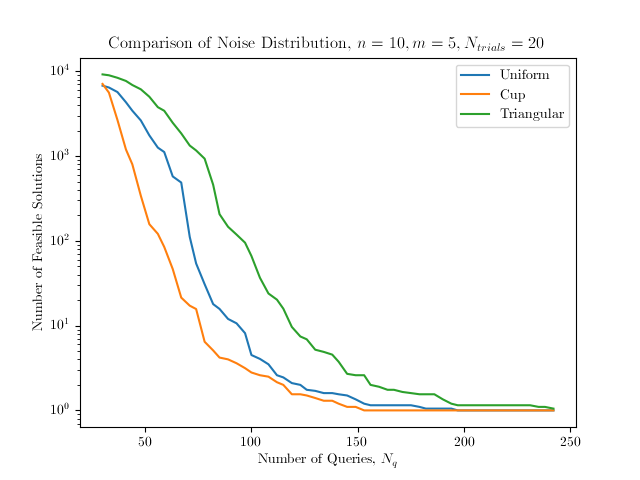

In [68]:
plt.figure()
x = N_q_range_update
keys = res_dict.keys()
names = ['Uniform', 'Cup', 'Triangular']
oo = 0
for key in keys:
    y = res_dict[key]
    plt.plot(x, y, label = f'{names[oo]}')
    oo+=1
plt.xlabel('Number of Queries, $N_q$')
plt.ylabel('Number of Feasible Solutions')
# plt.xscale('log')
plt.yscale('log')
plt.title("Comparison of Noise Distribution, $n=10,m=5,N_{trials}=20$")
# plt.title(f'{heading_dict[feature]} for varying $c, m=5, n=30, N_{{trials}} =30$')
# plt.title(f"$c$")
# plt.ylim([0,105])
plt.legend()

# filename = f'../compare_noise_dist/figures/n_10_m_5_c_1_Nt_20.pdf'
filename = f'../compare_noise_dist/figures/n_10_m_5_Nt_20_c_1_prob_dicts.pdf'
os.makedirs(os.path.dirname(filename), exist_ok=True)

plt.savefig(filename,bbox_inches='tight') 
plt.show()

In [547]:
n = 2
m = 7
c = 5
print(f'maximum queries: {max_quers(m)}')
dist = 'uniform'
db = gen_bin_data_set(n,m)
display(db)
N_sols = 10000
quer_seed_dict = query_seed_dict(m)
all_quer_counts = get_quer_counts(db,m,c,quer_seed_dict,dist)
n_queries = 1200

sample_quers = gen_queries_uniform_complete(m,n_queries)
target_quers = [((0,), (0,)), ((0,), (1,)), (tuple([x for x in range(m)]), tuple([0 for x in range(m)]))]
print(all_quer_counts[target_quers[0]])

if target_quers[0] in sample_quers:
    print(f'Query contained in sample, value is {all_quer_counts[target_quers[0]]}')

current_quers_dict = dict((i,all_quer_counts[i]) for i in sample_quers)
print(target_quer_vals_ILP(c,m,n,current_quers_dict,target_quers,N_sols))

# print(n_sols(n,m,current_quers_dict,c,N_sols))
# feasible_sols = gen_sols(n,m,current_quers_dict,dict(),c,N_sols)[0]
# lst = []
# for sol in feasible_sols:
#     sol_db = pd.DataFrame(sol, columns=[f'att_{x}' for x in range(m)])
#     lst.append(get_counts_uniform(sol_db,[target_quers[0]],0)[tuple([target_quers[0]][0])])
# print(set(lst))

maximum queries: 2186


,att_0,att_1,att_2,att_3,att_4,att_5,att_6
0,0,1,1,0,1,0,1
1,0,0,0,1,0,1,1


7
Query contained in sample, value is 7
new_ILP: 1 solutions
{((0,), (0,)): {2}, ((0,), (1,)): {0}, ((0, 1, 2, 3, 4, 5, 6), (0, 0, 0, 0, 0, 0, 0)): {0}}


In [941]:
def get_noise_dist(db,quer_dict,m,comp_dict = None):
    """ takes a db and a set of noisy counts, and return a dictionary of queries with the noise
    applied to each query"""
    if comp_dict == None:
        all_quers = gen_queries_all(m)
        true_counts = get_counts_uniform(db,all_quers,0)
        true_counts[((),())] = len(db)
    else:
        true_counts = comp_dict
    out_dict = defaultdict()
    for quer in true_counts.keys():
        out_dict[quer] = quer_dict[quer] - true_counts[quer]
    return out_dict

def get_prob_dict(db,quer_dict,m,c,noise_dists):
    """generates a probability distribution based on a list of different counting queries"""
    vals = []
    for config in noise_dists:
        vals += list(get_noise_dist(db,config,m).values())
    prob_dict = defaultdict()
    for i in range(-c,c+1):
        prob_dict[i] = vals.count(i)/len(vals)
    return prob_dict

def get_margin_consistent_noise_dist(n,m,c,db,Nq_mc,N_q,n_fixed):
    all_noise_dists = margin_consistent_queries_ILP(db,c,m,n,Nq_mc,n_fixed)
    
    temp = []
    
    all_quers = gen_queries_all(m)
    comp_dict = get_counts_uniform(db,all_quers,0)
    comp_dict[((),())] = len(db)
    for sol in all_noise_dists[0]:
        temp.append(get_noise_dist(db,sol,m,comp_dict))
    
    
    print(f'number of possible noise instances: {len(all_noise_dists[0])}')
    quers_true_margins = all_noise_dists[0][int(np.random.randint(len(all_noise_dists[0])))]
    instance = all_noise_dists[1]
    
    # print(f'possible nois dists: {[get_noise_dist(db,x,m) for x in all_noise_dists[0]]}')
    # print(f'actual choice: {quers_true_margins}')
    # print(f'noise dist: {quers_true_margins}')
    
    quers = gen_queries_comp(m)
    np.random.shuffle(quers)
    queries = quers[0:N_q]
    quer_dict_margins = dict((k, quers_true_margins[k]) for k in queries)
    
    # print(get_prob_dict(db,quer_dict,m,c,all_noise_dists[1]))
    
    # return quer_dict_margins, instance
    return temp
                     
n = 1000
n_fixed = None
m = 4
db = gen_bin_data_set(n,m)
c = 1
N_q = max_quers(m)
N_sols = 100000
Nq_mc = 100000
# display(db)


all_quers = gen_queries_all(m)
true_counts = get_counts_uniform(db,all_quers,0)
# print(true_counts)
configs_m4 = get_margin_consistent_noise_dist(n,m,c,db,Nq_mc,N_q,n_fixed)


quer_dict,instance = get_margin_consistent_noise_dist(n,m,c,db,Nq_mc,N_q,n_fixed)
# display(quer_dict)
# ILP_res = target_quer_vals_ILP(c,m,n,quer_dict,None,N_sols)
# print(ILP_res[1])
count = 0
true_count = 0
# for dict1 in ILP_res[1]:
#     # print(dict1)
#     # print(get_noise_dist(db,dict1,m,quer_dict))
#     true_count += check_margin_consistent(dict1,m)
#     for dict2 in instance:
#         if dict1==dict2:
#         # if get_noise_dist(db,dict1,m) == get_noise_dist(db,dict2,m):
#             count+=1
            # print('_',dict1)
            
# for i in ILP_res[1]:
#     print(i)
# print(f'number of margin consistent sols: {true_count}')
# print(f'number of matches: {count}')
# print(f'number of feasible solutions: {ILP_res[0]}')
# print(n_sols(n,m,quer_dict,c,N_sols))


number of possible noise instances: 29875
number of possible noise instances: 29875


ValueError: too many values to unpack (expected 2)

In [1118]:
7*31 - 15 + 3**2
# 31*403 - 211  + 4345
# len(configs_m3)

208

c=1: 1 -> 3, 2 -> 15, 3 -> 211, 4 -> 16627,
c=2: 1 -> 5, 2 -> 65, 3 -> 5815, 4 -> 
c=3: 1 -> 7, 2 -> 175, 3-> 56893
c=4: 1 -> 9, 2 -> 369,
c=5: 1 -> 11, 2-> 671, 
_______________________________
Not fixing value of $n$ we get:
7, 31, 403, 29875

1,211,5815,56893

8,48,144,320

In [606]:
def force_zeros(db,quer_dict,c):
    """ensures that zeros stay zero in a set of queries.
    Bit of a hack job, would be better to identify zeros 
    before adding noise and then not applying noise to those rather
    than checking any quers below wtih value <= c"""
    check_quers = []
    for quer, val in quer_dict.items():
        if val <= c:
            check_quers.append(quer)
    true_counts = get_counts_uniform(db,check_quers,0)
    out_dict = dict(quer_dict)
    for quer, val in true_counts.items():
        if val == 0:
            out_dict[quer] = 0
    return out_dict

def compare_zeros(n,m,c,N_sols,N_trials,N_q_range):
    """
    comparing zeros stay zero against normal
    
    """
    results = defaultdict(list)
    target_quers = None
    for i in range(N_trials):
        print(i)
        quer_seed_dict = query_seed_dict(m)
        quers_all = gen_queries_uniform_complete(m,max_quers(m))
        db = gen_bin_data_set(n,m)
        for zeros_switch in [False,True]:
            # partials_temp = gen_partial_info(db,partial[0],partial[1])
            # print(partial_dict)
            
            temp_res = []
            for N_q_try in N_q_range:
                N_q = int(min(N_q_try,max_quers(m)))
                quers = quers_all[0:N_q]
                noisy_counts_all = get_counts_uniform_seed(db,quers,c,quer_seed_dict)
                
                if zeros_switch == True:
                    quer_dict =  force_zeros(db,noisy_counts_all,c)
                elif zeros_switch == False:
                    quer_dict = dict(noisy_counts_all)

                temp_res.append(target_quer_vals_ILP(c,m,n,quer_dict,target_quers,N_sols,get_n_sols = True,zeros = zeros_switch))
            results[str(zeros_switch)].append(temp_res)
            
    nq_range = [int(min(N_q_try,max_quers(m))) for N_q_try in N_q_range]
    
    out_results = defaultdict()
    # print(results)
    for i in results.keys():
        
        out_results[i] = [sum([results[i][x][j] for x in range(N_trials)])/N_trials for j in range(len(nq_range))] 
    
    return out_results, nq_range

In [621]:
c = 2
m = 5
n = 20
N_q_range = np.linspace(50,250,20)
N_sols = 10000
N_trials = 20
data_zeros = compare_zeros(n,m,c,N_sols,N_trials,N_q_range)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


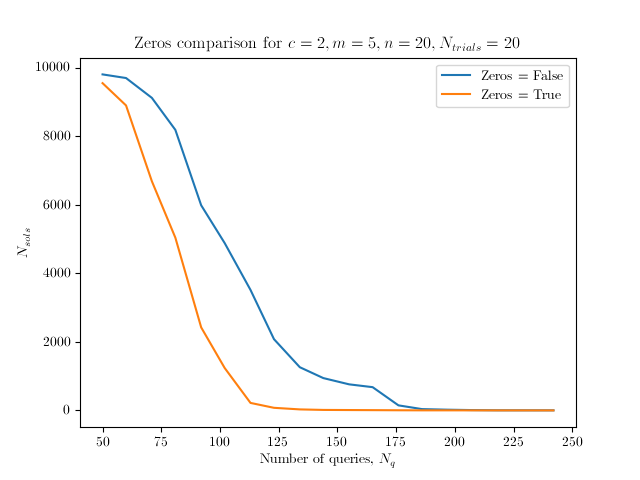

In [626]:
c = 2
m = 5
n = 20
N_q_range = np.linspace(50,250,20)
N_sols = 10000
N_trials = 20

plt.figure()

x = data_zeros[1]
for i in data_zeros[0].keys():
    y = data_zeros[0][i]
    plt.plot(x, y, label = f'Zeros = {i}')

    
plt.xlabel('Number of queries, $N_q$')
plt.ylabel('$N_{sols}$')
# plt.xscale('log')
# plt.yscale('log')
# plt.title("Averages of methods, 40 trials, n=10, m=4, c=1")
plt.title(f'Zeros comparison for $c={c}, m={m}, n={n}, N_{{trials}} ={N_trials}$')
# plt.title(f"$c$")
# plt.ylim([0,105])
plt.legend()
# plt.savefig(f'../zeros_comparison/figures/c_{c}_m_{m}_n_{n}_first.pdf') 
plt.show()
# plt.close()

In [604]:
n = 2
m = 2
c = 2
print(f'maximum queries: {max_quers(m)}')
dist = 'uniform'
db = gen_bin_data_set(n,m)
display(db)
N_sols = 10000
quer_seed_dict = query_seed_dict(m)
all_quer_counts = get_quer_counts(db,m,c,quer_seed_dict,dist)
display(all_quer_counts)
display(force_zeros(db,all_quer_counts,c))
display(all_quer_counts)
target_quers = None

# print(target_quer_vals_ILP(c,m,n,all_quer_counts,target_quers,N_sols,get_n_sols = True,zeros = False))
# print(target_quer_vals_ILP(c,m,n,force_zeros(db,all_quer_counts,c),target_quers,N_sols,get_n_sols = True,zeros = True))

maximum queries: 8


,att_0,att_1
0,0,1
1,0,1


defaultdict(int,
            {((0,), (0,)): 2,
             ((1,), (1,)): 0,
             ((0, 1), (1, 0)): 1,
             ((0, 1), (0, 1)): 2,
             ((0, 1), (1, 1)): 0,
             ((1,), (0,)): 2,
             ((0, 1), (0, 0)): 0,
             ((0,), (1,)): 0})

{((0,), (0,)): 2,
 ((1,), (1,)): 0,
 ((0, 1), (1, 0)): 0,
 ((0, 1), (0, 1)): 2,
 ((0, 1), (1, 1)): 0,
 ((1,), (0,)): 0,
 ((0, 1), (0, 0)): 0,
 ((0,), (1,)): 0}

defaultdict(int,
            {((0,), (0,)): 2,
             ((1,), (1,)): 0,
             ((0, 1), (1, 0)): 1,
             ((0, 1), (0, 1)): 2,
             ((0, 1), (1, 1)): 0,
             ((1,), (0,)): 2,
             ((0, 1), (0, 0)): 0,
             ((0,), (1,)): 0})

In [874]:
configs_m1

[defaultdict(None, {((0,), (0,)): -1, ((0,), (1,)): 1, ((), ()): 0}),
 defaultdict(None, {((0,), (0,)): 1, ((0,), (1,)): -1, ((), ()): 0}),
 defaultdict(None, {((0,), (0,)): 0, ((0,), (1,)): 0, ((), ()): 0})]

In [1139]:
def ccub(n,e):
    return n**e + (n-1)**e

def spn(n,e):
    return n**e - (n - 1)**e

n=1
e=4
print(spn(n,e))

def table_int(lsts,display=False):
    set_lsts = [set([tuple(x.items()) for x in lst]) for lst in lsts]
    intersection = set_lsts[0].intersection(*set_lsts)
    if display == True:
        for s in intersection:
            print(dict2pandas_2d(dict(s)))
    return len(intersection)

1


In [1152]:
bottom_zeros = [s for s in configs_m2 if s[((0,), (0,))] != (0) and s[((), ())] == (0)]
print(len(bottom_zeros))
side_zeros = [s for s in configs_m2 if s[((1,), (0,))] != (0) and s[((), ())] == (0)]
print(table_int([bottom_zeros,side_zeros],display=False))

8
4


In [1193]:
# print(len(configs_m1))
bottom_zeros = [s for s in configs_m3 if s[((1,), (0,))] == (0) and s[((0,), (0,))] == (0) and s[((0,1),(0,0))]==0 and s[((), ())] == (0)]
print(len(bottom_zeros))
side_zeros = [s for s in configs_m3 if s[((2,), (0,))] == (0) and s[((0,), (0,))] == (0) and s[((0,2),(0,0))]==0 and s[((), ())] == (0)]
depth_zeros = [s for s in configs_m3 if s[((1,), (0,))] == (0) and s[((2,), (0,))] == (0) and s[((1,2),(0,0))]==0 and s[((), ())] == (0)]
print(table_int([bottom_zeros,side_zeros],display=False))
# others = [s for s in configs_m2 if s[((0,), (0,))] != (0) and s[((1,), (0,))] != (0) and s[((), ())] == (0)]
# for i in others:
#     display(dict2pandas(i))
bottom_zeros = [s for s in configs_m3 if s[((1,), (0,))] != (0) and s[((0,), (0,))] != (0) and s[((0,1),(0,0))]==0 and s[((), ())] == (0)]
print(len(bottom_zeros))
side_zeros = [s for s in configs_m3 if s[((2,), (0,))] != (0) and s[((0,), (0,))] != (0) and s[((0,2),(0,0))]==0 and s[((), ())] == (0)]
depth_zeros = [s for s in configs_m3 if s[((1,), (0,))] != (0) and s[((2,), (0,))] != (0) and s[((1,2),(0,0))]==0 and s[((), ())] == (0)]
print(table_int([bottom_zeros,side_zeros],display=False))
aa = [s for s in configs_m2 if s[((), ())] == (0)]
bb = [s for s in configs_m2 if s[((0,), (0,))] == (0)]
print(table_int([aa,bb],display=False))
print(len([s for s in configs_m2 if s[((0,), (0,))] == (0)  and s[((), ())] == (0) ] ))

31
7
20
4
7
7


In [1192]:
output_1d = np.zeros((3))

for i in range(3):
    output_1d[i] = len([s for s in configs_m1 if s[((0,), (0,))] == (i-1) 
                        # and s[((), ())] == (0)
                       ])
        
print(output_1d)

output_2d = np.zeros((3))

for i in range(3):
    output_2d[i] = len([s for s in configs_m2 if s[((0,), (0,))] == (i-1) and s[((1,), (0,))] == (0)
                       # and s[((), ())] == (0)
                       ])
print(output_2d)
    
count =0
for s in configs_m2:
    # if s[((), ())] == (0) and s[((1,), (0,))] != (0) and s[((0,), (0,))] != (0):
    if s[((), ())] == (0) and s[((1,), (0,))]==0 :
    # if s[((), ())] == (0) :

        # display(dict2pandas_2d(s))
        count+=1
print(count)
print(output_2d)

# display(configs_m2)

output_3d = np.zeros((3))

# for i in range(3):
#     output_3d[i] = len([s for s in configs_m3 if s[((0,), (0,))] == (i-1) and s[((1,), (0,))] == (0) and s[((2,), (0,))] == (0)
#                         and s[((), ())] == (0)
#                        ])
    
# for i in range(3):
#     output_3d[i] = len([s for s in configs_m3 if s[((0,1), (0,0))] == (i-1) and s[((0,2), (0,0))] == (0) and s[((), ())] == (0)
#                        ])

output_2d = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        output_2d[i,j] = len([s for s in configs_m2 if s[((0,), (0,))] == (i-1) and s[((1,), (0,))] == (j-1)])
# display([s for s in configs_m2 if s[((0,), (0,))] == (-1) and s[((1,), (0,))] == (-1)])
# print(output_2d)
    
output_3d = np.zeros((3,3))
for i in range(3):
    for j in range(3):
        output_3d[i,j] = len([s for s in configs_m3 if s[((0,), (0,))] == (i-1) and s[((1,), (0,))] == (j-1) and s[((2,),(0,))] == 0 and
                             s[(0,2),(0,0)] == 0 and s[(1,2),(0,0)] == 0 ])
# display([s for s in configs_m3 if s[((0,), (0,))] == (-1) and s[((1,), (0,))] == (-1) and s[((2,),(0,))] == 0 and
#                              s[(0,2),(0,0)] == 0 and s[(1,2),(0,0)] == 0 ])
# print(output_3d)

        
# print(output_3d)

# output_4d = np.zeros((3))

# for i in range(3):
#     output_4d[i] = len([s for s in configs_m4 if s[((0,1,2,3), (0,0,0,0))] == (i-1)])
        
# print(output_4d)

[2. 3. 2.]
[4. 7. 4.]
7
[4. 7. 4.]


In [870]:
# display(configs)

# display(configs_m3)
output_2d = np.zeros((3,3))

for i in range(3):
    for j in range(3):
        output_2d[i,j] = len([s for s in configs if s[((0,), (0,))] == (i-1) and s[((1,), (0,))] == (j-1)])
        
print(output_2d)

# qqq = len([s for s in configs if s[((0,), (0,))] == 1 and s[((1,), (0,))] == -1])
# display(qqq)



[4. 7. 4.]


In [869]:
# display(configs_m3)
# output = np.zeros((3,3,3))
# display(output)

# display(configs_m3)

# display(configs_m3)
output_3d = np.zeros((3,3))

for i in range(3):
    for j in range(3):
        output_3d[i,j] = len([s for s in configs_m3 if s[((0,2), (0,0))] == (i-1) and s[((1,2), (0,0))] == (j-1)])
print(output_3d)

# options = [-1,0,1]
# for i in options:
#     for j in options:
#         for k in options:
#             output[i,j,k] = len([s for s in configs_m3 if s[((0,), (0,))] == i and s[((1,), (0,))] == j and s[((2,), (0,))] == k])
            
# print(output)


# faces = np.zeros((3,2,2,3))
# faces_dims = [(0, 1), (0, 2), (1, 2)]
# for i in options:
#     for j in [0, 1]:
#         for k in [0, 1]:
#             for l in [-1, 0, 1]:
#                 faces[i,j,k,l] = len([s for s in configs_m3 if s[(faces_dims[i], (j, k))] == l])
            
display(faces)
print(np.sum(faces))

qqq = ([s for s in configs_m3 if s[((0,), (0,))] == (-1) and s[((1,), (0,))] == (-1) and s[((2,), (0,))] == (-1)])
# display(qqq)
display(qqq[0])
            
print(np.sum(output))

            
# qqq = len([s for s in configs_m3 if s[((0,), (0,))] == 1 and s[((1,), (0,))] == -1])
# display(qqq)

[[18. 28.  6.]
 [28. 51. 28.]
 [ 6. 28. 18.]]


array([[[[107.,  52.,  52.],
         [107.,  52.,  52.]],

        [[107.,  52.,  52.],
         [107.,  52.,  52.]]],


       [[[107.,  52.,  52.],
         [107.,  52.,  52.]],

        [[107.,  52.,  52.],
         [107.,  52.,  52.]]],


       [[[107.,  52.,  52.],
         [107.,  52.,  52.]],

        [[107.,  52.,  52.],
         [107.,  52.,  52.]]]])

2532.0


defaultdict(None,
            {((0,), (0,)): -1,
             ((0,), (1,)): 1,
             ((1,), (0,)): -1,
             ((1,), (1,)): 1,
             ((2,), (0,)): -1,
             ((2,), (1,)): 1,
             ((0, 1), (0, 0)): -1,
             ((0, 1), (0, 1)): 0,
             ((0, 1), (1, 0)): 0,
             ((0, 1), (1, 1)): 1,
             ((0, 2), (0, 0)): -1,
             ((0, 2), (0, 1)): 0,
             ((0, 2), (1, 0)): 0,
             ((0, 2), (1, 1)): 1,
             ((1, 2), (0, 0)): -1,
             ((1, 2), (0, 1)): 0,
             ((1, 2), (1, 0)): 0,
             ((1, 2), (1, 1)): 1,
             ((0, 1, 2), (0, 0, 0)): 0,
             ((0, 1, 2), (0, 0, 1)): -1,
             ((0, 1, 2), (0, 1, 0)): -1,
             ((0, 1, 2), (0, 1, 1)): 1,
             ((0, 1, 2), (1, 0, 0)): -1,
             ((0, 1, 2), (1, 0, 1)): 1,
             ((0, 1, 2), (1, 1, 0)): 1,
             ((0, 1, 2), (1, 1, 1)): 0,
             ((), ()): 0})

211.0


In [835]:
# display(configs_m3)
output = np.zeros((3,3,3,3))

# display(configs_m3)

ccc = 1
ccc_range = 2*ccc + 1
for i in range(ccc_range):
    for j in range(ccc_range):
        for k in range(ccc_range):
            for l in range(ccc_range):
            # for l in [1]:
                output[i,j,k,l] = len([s for s in configs_m4 if s[((0,), (0,))] == (i-1) and s[((1,), (0,))] == (j-1) and s[((2,), (0,))] == (k-1) and s[((3,), (0,))] == (l-1)])

# qqq = ([s for s in configs_m3 if s[((0,), (0,))] == (-1) and s[((1,), (0,))] == (-1) and s[((2,), (0,))] == (-1)])
# display(qqq)
            
print(np.sum(output))
print(output)

            
# qqq = len([s for s in configs_m3 if s[((0,), (0,))] == 1 and s[((1,), (0,))] == -1])
# display(qqq)

16627.0
[[[[  16.   68.   16.]
   [  68.  264.   68.]
   [  16.   68.   16.]]

  [[  68.  264.   68.]
   [ 264.  784.  264.]
   [  68.  264.   68.]]

  [[  16.   68.   16.]
   [  68.  264.   68.]
   [  16.   68.   16.]]]


 [[[  68.  264.   68.]
   [ 264.  784.  264.]
   [  68.  264.   68.]]

  [[ 264.  784.  264.]
   [ 784. 1587.  784.]
   [ 264.  784.  264.]]

  [[  68.  264.   68.]
   [ 264.  784.  264.]
   [  68.  264.   68.]]]


 [[[  16.   68.   16.]
   [  68.  264.   68.]
   [  16.   68.   16.]]

  [[  68.  264.   68.]
   [ 264.  784.  264.]
   [  68.  264.   68.]]

  [[  16.   68.   16.]
   [  68.  264.   68.]
   [  16.   68.   16.]]]]


In [1066]:
aaa = configs_m2[18]
display(aaa)

# for i, j in aaa.items():
#     print(i[0][0])

def dict2pandas_2d(quer_dict):
    out = np.zeros((3,3),dtype = int)
    out[0,0] = quer_dict[((0, 1), (0, 0))]
    out[0,1] = quer_dict[((0, 1), (0, 1))]
    out[1,0] = quer_dict[((0, 1), (1, 0))]
    out[1,1] = quer_dict[((0, 1), (1, 1))]
    out[0,2] = quer_dict[((0,), (0,))]
    out[1,2] = quer_dict[((0,), (1,))]
    out[2,0] = quer_dict[((1,), (0,))]
    out[2,1] = quer_dict[((1,), (1,))]
    out[2,2] = quer_dict[((), ())]    
    # print(out)
    out_df = pd.DataFrame(out)
    out_df.columns = ["0", "1", "Total"]
    out_df = out_df.rename(index={0: "0", 1: "1", 2: "Total"})
    out_df = out_df.rename_axis("att 0:")
    out_df = out_df.rename_axis("att 1:", axis="columns")
    return(out_df)


display(dict2pandas_2d(aaa))

defaultdict(None,
            {((0,), (0,)): 1,
             ((0,), (1,)): -1,
             ((1,), (0,)): 1,
             ((1,), (1,)): -1,
             ((0, 1), (0, 0)): 1,
             ((0, 1), (0, 1)): 0,
             ((0, 1), (1, 0)): 0,
             ((0, 1), (1, 1)): -1,
             ((), ()): 0})

att 1:,0,1,Total
att 0:,,,
0,1,0,1
1,0,-1,-1
Total,1,-1,0


In [1187]:
configs_all = [configs_m1, configs_m2, configs_m3, configs_m4]

# condition_example = {((1,), (0,)): 0, ((0,), (0,)): 0}

def check_conditions(config, conditions):
    for condition, val in conditions.items():
        if config[condition] != val:
            return False
    return True

def count_condition(configs, conditions):
    if conditions == None:
        return len(configs)
    for condition in conditions.keys():
        if condition not in configs[0].keys():
            return 'N/A'
        
    satisfied = []
    for config in configs:
        if check_conditions(config, conditions):
            satisfied.append(config)
    return len(satisfied)

    
    
conditions_all = [None,
                  {((),()): 0}, 
                  {((),()): 1}, 
                  {((0,), (0,)): 0},
                  {((0,), (0,)): 1},
                  {((),()): 0, ((0,), (0,)): 0},
                  {((),()): 1, ((0,), (0,)): 0},
                  {((1,), (0,)): 0, ((0,), (0,)): 0},
                  {((1,), (0,)): 0, ((0,), (0,)): 0, ((),()): 0},
                  {((1,), (0,)): 1, ((0,), (0,)): 0, ((),()): 0},
                  {((1,), (0,)): 1, ((0,), (0,)): 1, ((),()): 0},
                  {((1,), (0,)): 1, ((0,), (0,)): 1, ((),()): 1},
                  {((1,), (0,)): 0, ((0,), (0,)): 1, ((),()): 1},
                  {((1,), (0,)): 0, ((0,), (0,)): 0, ((),()): 1},
                  
                  {((0, 1), (0, 0)): 0},
                  {((0, 1), (0, 0)): 0, ((),()): 0},
                  {((0, 1), (0, 0)): 0, ((),()): 1},
                  {((1,), (0,)): 0, ((0,), (0,)): 0, ((0, 1), (0, 0)): 0, ((),()): 0},
                  {((1,), (0,)): 0, ((0,), (0,)): 0, ((0, 1), (0, 0)): 0, ((),()): 1},
                  {((1,), (0,)): 0, ((0,), (0,)): 0, ((0, 1), (0, 0)): 1, ((),()): 1},
                  # {((1,), (0,)): 0, ((0,), (0,)): 0, ((),()): 1},
                  # {((1,), (0,)): 0, ((0,), (0,)): 0, ((),()): 1},
                  
                  {((1,), (0,)): 0, ((0,), (0,)): 0, ((2,), (0,)): 0},
                  {((1,), (0,)): 0, ((0,), (0,)): 0, ((2,), (0,)): 0, ((),()): 0},
                  {((1,), (0,)): 1, ((0,), (0,)): 0, ((2,), (0,)): 0, ((),()): 0},
                  {((1,), (0,)): 1, ((0,), (0,)): 1, ((2,), (0,)): 0, ((),()): 0},
                  {((1,), (0,)): 1, ((0,), (0,)): 1, ((2,), (0,)): 1, ((),()): 0},
                  {((1,), (0,)): 0, ((0,), (0,)): 0, ((2,), (0,)): 0, ((),()): 1},
                  {((1,), (0,)): 0, ((0,), (0,)): 0, ((2,), (0,)): 1, ((),()): 1},
                  {((1,), (0,)): 0, ((0,), (0,)): 1, ((2,), (0,)): 1, ((),()): 1},
                  {((1,), (0,)): 1, ((0,), (0,)): 1, ((2,), (0,)): 1, ((),()): 1},
                  {((1,), (0,)): 1, ((0,), (0,)): 1, ((2,), (0,)): 1,((3,), (0,)): 1, ((),()): 1},
                  {((1,), (0,)): 1, ((0,), (0,)): 1, ((2,), (0,)): 1,((3,), (0,)): 1, ((0,1), (0,0)): 1, ((),()): 1},
                  {((1,), (0,)): 1, ((0,), (0,)): 1, ((2,), (0,)): 1,((3,), (0,)): 1, ((0,1,2,3), (0,0,0,0)): 1, ((),()): 1},
                  
                  {((0,1,2,3),(0,0,0,0)): 0, },
                  {((0,1,2,3),(0,0,0,0)): 0, ((),()): 0,},
                  {((0,1,2,3),(0,0,0,0)): 0, ((0,),(0,)): 0,},
                  
                 
                 
                 
                 ]
csv_lst = []
for conditions in conditions_all:
    out_dict = dict()
    out_dict['conditions'] =  str(conditions)
    for dim, configs in enumerate(configs_all):
        dim += 1
        out_dict[f'dim = {dim}'] = count_condition(configs, conditions)
    csv_lst.append(out_dict)
# print(csv_lst)
display(pd.DataFrame(csv_lst))

field_names = ['conditions', 'dim = 1', 'dim = 2', 'dim = 3', 'dim = 4']
with open('margin_consistent_counts.csv', 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames = field_names)
    writer.writeheader()
    writer.writerows(csv_lst)
    
    

,conditions,dim = 1,dim = 2,dim = 3,dim = 4
0,None,7,31,403,29875
1,"{((), ()): 0}",3,15,211,16627
2,"{((), ()): 1}",2,8,96,6624
3,"{((0,), (0,)): 0}",3,15,211,16627
4,"{((0,), (0,)): 1}",2,8,96,6624
5,"{((), ()): 0, ((0,), (0,)): 0}",1,7,115,10003
6,"{((), ()): 1, ((0,), (0,)): 0}",1,4,48,3312
7,"{((1,), (0,)): 0, ((0,), (0,)): 0}",N/A,7,107,9091
8,"{((1,), (0,)): 0, ((0,), (0,)): 0, ((), ()): 0}",N/A,3,59,5779
9,"{((1,), (0,)): 1, ((0,), (0,)): 0, ((), ()): 0}",N/A,2,28,2112


In [1167]:
os.getcwd()

'/Users/hmcarthur/initial_explorations/toy_model_ILP/ILP_solving_queries'

In [1246]:
from math import comb
# comb(10,3)

def all_formula(r,c):
    n = len(c)
    total = 0
    for sigma in get_sigmas(n):
        # print(sigma)
        total += choose_part(r,c,sigma,n)*((-1)**len(sigma))
    return total
    
def choose_part(r,c,sigma,n):
    # print("ffff",c_sigma(c,sigma))
    top = r[0] - c_sigma(c,sigma) - len(sigma)
    bottom = n - 1
    # print(top)
    # print(bottom)
    # if top + bottom < 0:
    #     return ((-1)**bottom)*comb(top+2*bottom-1,bottom)  
    # else:
    return comb(top + bottom, bottom)
    
def c_sigma(c,sigma):
    
    return sum([c[i] for i in sigma])

def get_sigmas(n):
    choice = gen_powerset(n)
    out = []
    for i in choice:
        temp = []
        for idx, val in enumerate(i):
            if val == 1:
                temp.append(idx)
        out.append(temp)
    return out[1:]


In [1248]:
all_formula([2,2],[2,2])
# get_sigmas(2)

ValueError: n must be a non-negative integer

In [ ]:
def alternate_form(r,c):
    """ r is long vector, c is 2 dim vector"""
    I = len(r)
    coeff = 1/(math.gamma(I)*(np.prod(r)))
    

In [1256]:
np.prod([1,2,3])

6